# Linear regression with Eustatic Sea-level data

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/linear_regression/linear_regression_sealevel.ipynb)

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

---

## What we do in this notebook

Here we demonstrate use of CoFI on a real dataset **linear regression** problem, where we fit a polynomial function to Eustatic Sea-level heights.

- by solution of a linear system of equations,
- by optimization of a data misfit function
- by Bayesian sampling of a Likelihood multiplied by a prior.

---

Data set is from "Sea level and global ice volumes from the Last Glacial Maximum to the Holocene"
K. Lambeck, H. Rouby, A. Purcell, Y. Sun, and M. Sambridge, 2014. 
Proc. Nat. Acad. Sci., 111, no. 43, 15296-15303, doi:10.1073/pnas.1411762111.

In [1]:
# Environment setup (uncomment code below)

# !pip install -U cofi

Remember to uncomment and run the code cell below as well, as we are going to
load some data from GitHub.

In [2]:
# !git clone https://github.com/inlab-geo/cofi-examples.git
# %cd cofi-examples/examples/linear_regression

## Linear regression

Lets start with some (x,y) data.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#
def load_data_xy(filename):

    f = open(filename, 'r')
    header = f.readline()
    lines = f.readlines()

    x = np.array([])
    y = np.array([])
    sx = np.array([])
    sy = np.array([])
    for line in lines:
        columns = line.split()
        x = np.append(x,float(columns[0]))
        y = np.append(y,float(columns[1]))
        sx = np.append(sx,float(columns[2])/2.0)
        sy = np.append(sy,float(columns[3])/2.0)

    d = x,y, sy                                   # Combine into a single data structure

    return d

def load_data_ref(filename):

    f = open(filename, 'r')
    lines = f.readlines()
    dx = np.array([]) # Age data
    dy = np.array([]) # ESL height
    dz = np.array([]) # derivative of ESL w.r.t. age
    for line in lines:
        columns = line.split()
        dx = np.append(dx,float(columns[0]))
        dy = np.append(dy,float(columns[1]))
    datavals = np.column_stack((dx,dy))  # Stack data

    return datavals

In [5]:
data_x,data_y,sy = load_data_xy("ESL-ff11-sorted.txt")  # Load x,sx,y,sy ESL data (x=time, Y=ESL)

In [6]:
maxtime = 20.
ndata = np.where(data_x>maxtime)[0][0]

In [7]:
data_x,data_y,sy = data_x[:ndata],data_y[:ndata],sy[:ndata]

And now lets plot the data.

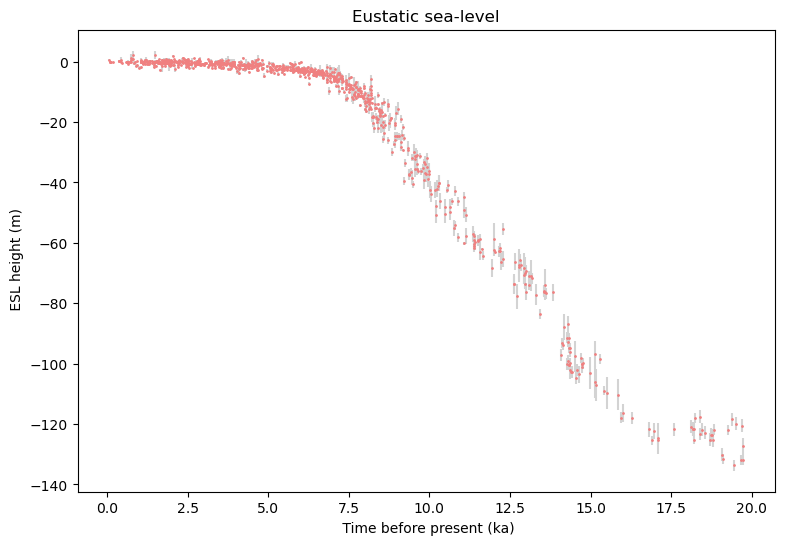

In [8]:
def plot_data(x=data_x,y=data_y,sigma=sy,title=None):
    fig, axes = plt.subplots(figsize=(9,6))
    plt.errorbar(x, y, yerr=sy, fmt='.',color="lightcoral",ecolor='lightgrey',ms=2)
    plt.xlabel(' Time before present (ka)')
    plt.ylabel(' ESL height (m)')
    if(title != None): plt.title(title)
plot_data(title='Eustatic sea-level')

## Problem description

To begin with, we will work with polynomial curves, $$y(x) = \sum_{j=0}^M m_j x^j\,.$$
Here, $M$ is the 'order' of the polynomial: if $M=1$ we have a straight line with 2 parameters, if $M=2$ it will be a quadratic with 3 parameters, and so on. The $m_j, (j=0,\dots M)$ are the 'model coefficients' that we seek to constrain from the data.

For this class of problem the forward operator takes the following form:

$$ \left(\begin{array}{c}y_0\\y_1\\\vdots\\y_N\end{array}\right) = \left(\begin{array}{ccc}1&x_0&x_0^2&x_0^3\\1&x_1&x_1^2&x_1^3\\\vdots&\vdots&\vdots\\1&x_N&x_N^2&x_N^3\end{array}\right)\left(\begin{array}{c}m_0\\m_1\\m_2\end{array}\right)$$


This clearly has the required general form, $\mathbf{d} =G{\mathbf m}$.

where:

- $\textbf{d}$ is the vector of data values, ($y_0,y_1,\dots,y_N$);
- $\textbf{m}$ is the vector of model parameters, ($m_0,m_1,m_2$);
- $G$ is the basis matrix (or design matrix) of this linear regression problem (also called the ***Jacobian*** matrix for this linear problem).



We have a set of noisy data values, $y_i (i=0,\dots,N)$, measured at known locations, $x_i (i=0,\dots,N)$, and wish to find the best fit degree 3 polynomial.

The function that generated our data is assumed to have independent Gaussian random noise, ${\cal N}(0,\Sigma)$, with $(\Sigma)_{ij} = \delta_{ij}/\sigma_i^2$, where the variance of the noise on each datum, $\sigma_i^2 (i=1,\dots,N)$, differs between observations and is given.

We now build the Jacobian/G matrix for this problem and define a forward function which simply multiplies $\mathbf m$ by $G$.

In [9]:
nparams = 5 # Number of model parameters to be solved for

def jacobian(x=data_x, n=nparams):
    return np.array([x**i for i in range(n)]).T

def forward(model):
    return jacobian().dot(model)

def Cd_inv(sigma=sy):
    factor= 10                                   # factor to inflate observational errors
    return np.diag(1./sy*1./sy)/(factor**2)

Define a reference model for later.

In [10]:
# Reference model for plotting
ESLref = load_data_ref("ESL-f11_yonly.txt") # Load x, y, z reference model and estimated derivative (x=time, Y=ESL, z=dESL/dt) 
ndata2 = np.where(ESLref.T[0]>maxtime)[0][0]
ESLref = ESLref[:ndata2]
ref_x,ref_y = ESLref.T[0],ESLref.T[1]

Now lets plot the data with the reference curve

In [11]:
# Some plotting utilities
def plot_model(x,y, label, color=None,lw=0.5):
    plt.plot(x, y, color=color or "green", label=label,lw=lw)
    #plt.xlabel("X")
    #plt.ylabel("ESL")
    plt.legend()

def plot_models(models, label="Posterior samples", color="seagreen", alpha=0.1,lw=0.5):
    G = jacobian(data_x)
    plt.plot(data_x, G.dot(models[0]), color=color, label=label, alpha=alpha,lw=lw)
    for m in models:
        plt.plot(data_x, G.dot(m), color=color, alpha=alpha,lw=lw)
    plt.legend()

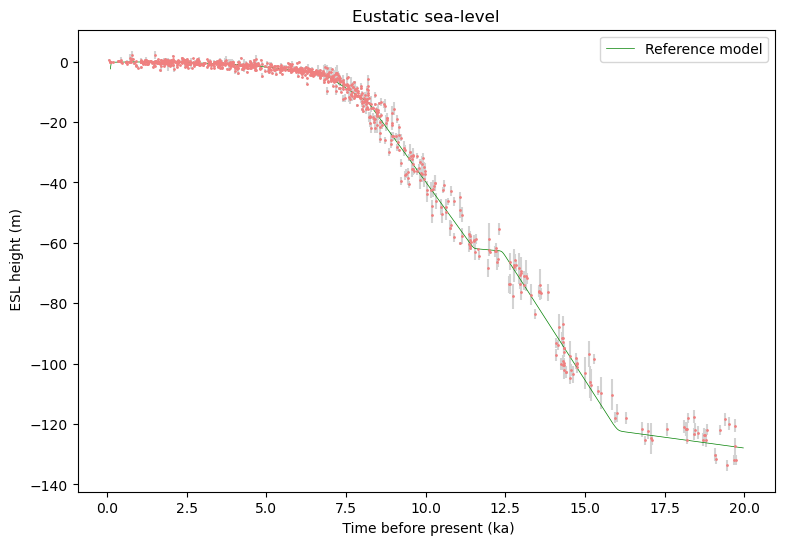

In [12]:
plot_data(title="Eustatic sea-level")
plot_model(ref_x,ref_y, "Reference model")

Now we have the data and the forward model we can start to try and estimate the coefficients of the polynomial from the data.

## The structure of CoFI <a name="CoFI-structure"></a>
In the workflow of `cofi`, there are three main 
components: `BaseProblem`, `InversionOptions`, and `Inversion`.

- `BaseProblem` defines the inverse problem including any user supplied quantities such as data vector, number of model parameters and measure of fit between model predictions and data. 
    ```python
    inv_problem = BaseProblem()
    inv_problem.set_objective(some_function_here)
    inv_problem.set_jacobian(some_function_here)
    inv_problem.set_initial_model(a_starting_point) # if needed, e.g. we are solving a nonlinear problem by optimization
    ```
    
    &nbsp; 
- `InversionOptions` describes details about how one wants to run the inversion, including the backend tool and solver-specific parameters. It is based on the concept of a `method` and `tool`.

    ```python
    inv_options = InversionOptions()
    inv_options.suggest_solving_methods()
    inv_options.set_solving_method("matrix solvers")
    inv_options.suggest_tools()
    inv_options.set_tool("scipy.linalg.lstsq")
    inv_options.summary()
    ```

    &nbsp; 
- `Inversion` can be seen as an inversion engine that takes in the above two as information,
  and will produce an `InversionResult` upon running.
  
    ```python
    inv = Inversion(inv_problem, inv_options)
    result = inv.run()
    ```
 
 Internally CoFI decides the nature of the problem from the quantities set by the user and performs internal checks to ensure it has all that it needs to solve a problem.

## 1. Linear system solver

In [13]:
from cofi import BaseProblem, InversionOptions, Inversion

### Step 1. Define CoFI `BaseProblem`

In [14]:
inv_problem = BaseProblem()
inv_problem.set_data(data_y)
inv_problem.set_jacobian(jacobian())
inv_problem.set_data_covariance_inv(Cd_inv())

### Step 2. Define CoFI `InversionOptions`

In [15]:
inv_options = InversionOptions()

Using the information supplied, we can ask CoFI to suggest some solving methods.

In [16]:
inv_options.suggest_solving_methods()

The following solving methods are supported:
{'optimization', 'sampling', 'matrix solvers'}

Use `suggest_tools()` to see a full list of backend tools for each method


We can ask CoFI to suggest some specific software tools as well. 

In [17]:
inv_options.suggest_tools()

Here's a complete list of inversion tools supported by CoFI (grouped by methods):
{
    "optimization": [
        "scipy.optimize.minimize",
        "scipy.optimize.least_squares",
        "torch.optim"
    ],
    "matrix solvers": [
        "scipy.linalg.lstsq",
        "cofi.simple_newton"
    ],
    "sampling": [
        "emcee"
    ]
}


In [18]:
inv_options.set_solving_method("matrix solvers") # lets decide to use a matrix solver.
inv_options.summary()

Summary for inversion options
Solving method: matrix solvers
Use `suggest_solving_methods()` to check available solving methods.
-----------------------------
Backend tool: `<class 'cofi.tools._scipy_lstsq.ScipyLstSq'> (by default)` - SciPy's wrapper function over LAPACK's linear least-squares solver, using 'gelsd', 'gelsy' (default), or 'gelss' as backend driver
References: ['https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html', 'https://www.netlib.org/lapack/lug/node27.html']
Use `suggest_tools()` to check available backend tools.
-----------------------------
Solver-specific parameters: None set
Use `suggest_solver_params()` to check required/optional solver-specific parameters.


In [19]:
# below is optional, as this has already been the default tool under "linear least square"
inv_options.set_tool("scipy.linalg.lstsq")

### Step 3. Define CoFI `Inversion` and run

Our choices so far have defined a linear parameter estimation problem (without any regularization) to be solved within a least squares framework. In this case 
the selection of a `matrix solvers` method will mean we are calculating the standard least squares solution 

$$
m = (G^T C_d^{-1} G)^{-1} G^T C_d^{-1} d
$$

and our choice of backend tool `scipy.linalg.lstsq`, means that we will employ scipy's `linalg` package to perform the numerics.

Lets run CoFI.

In [20]:
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

In [21]:
print(f"The inversion result from `scipy.linalg.lstsq`: {inv_result.model}\n")
inv_result.summary()

The inversion result from `scipy.linalg.lstsq`: [ 1.44051039 -3.11381469  1.412872   -0.20910136  0.00653572]

Summary for inversion result
SUCCESS
----------------------------
model: [ 1.44051039 -3.11381469  1.412872   -0.20910136  0.00653572]
sum_of_squared_residuals: []
effective_rank: 5
singular_values: [1.72339368e+09 1.35569994e+06 3.54123758e+03 1.10384400e+02
 7.16903392e+00]
model_covariance: [[ 6.70145209e-02 -6.28173834e-02  1.67266578e-02 -1.60867740e-03
   4.77025592e-05]
 [-6.28173834e-02  7.43365995e-02 -2.23488563e-02  2.32179303e-03
  -7.20214235e-05]
 [ 1.67266578e-02 -2.23488563e-02  7.38371078e-03 -8.20763652e-04
   2.65025504e-05]
 [-1.60867740e-03  2.32179303e-03 -8.20763652e-04  9.62437921e-05
  -3.21300646e-06]
 [ 4.77025592e-05 -7.20214235e-05  2.65025504e-05 -3.21300646e-06
   1.10114955e-07]]


Lets plot the solution.

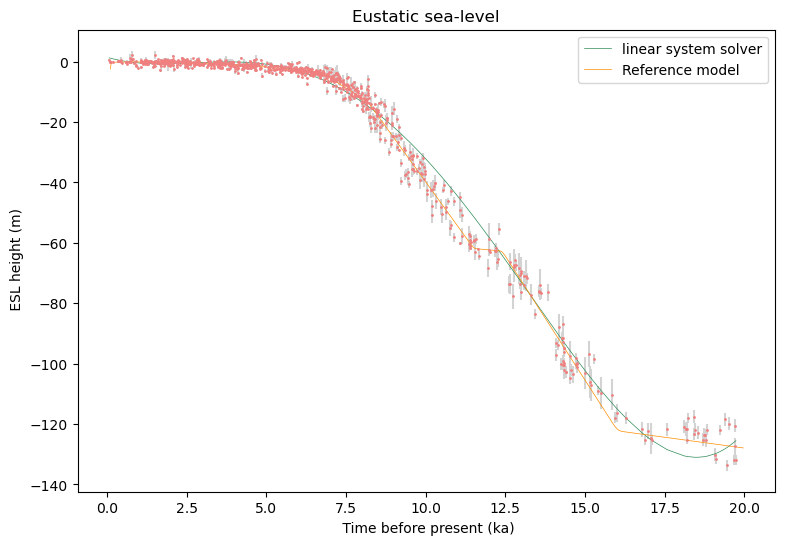

In [22]:
plot_data(title="Eustatic sea-level")
plot_model(data_x,jacobian(data_x).dot(inv_result.model), "linear system solver", color="seagreen")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

## 2. Optimizer

The same overdetermined linear problem, $\textbf{d} = G\textbf{m}$, with Gaussian data noise can also be solved by minimising the squares of the 
residual of the linear equations, e.g. $\textbf{r}^T \textbf{C}_d^{-1}\textbf{r}$ where 
$\textbf{r}=\textbf{d}-G\textbf{m}$. The above matrix solver solution gives us the best data fitting model, but a direct optimisation approach could also be used, say when the number of unknowns is large and we do not wish, or are unable to provide the Jacobian function.

So we use a plain optimizer `scipy.optimize.minimize` to demonstrate this ability.

<!-- For this backend solver to run successfully, some additional information should be provided, otherwise
you'll see an error to notify what additional information is required by the solver.

There are several ways to provide the information needed to solve an inverse problem with 
CoFI. In the example below we provide functions to calculate the data and the optional 
regularisation. CoFI then generates the objective function for us based on the information 
provided. The alternative to this would be to directly provide objective function to CoFI. -->

In [23]:
######## CoFI BaseProblem - provide additional information
inv_problem.set_initial_model(np.ones(nparams))
#inv_problem.set_initial_model(inv_result.model)
inv_problem.set_forward(forward)
inv_problem.set_data_misfit("squared error")

# inv_problem.set_objective(your_own_misfit_function)    # (optionally) if you'd like to define your own misfit
# inv_problem.set_gradient(your_own_gradient_of_misfit_function)    # (optionally) if you'd like to define your own misfit gradient

######## CoFI InversionOptions - set a different tool
inv_options_2 = InversionOptions()
inv_options_2.set_tool("scipy.optimize.minimize")
inv_options_2.set_params(method="Nelder-Mead")

######## CoFI Inversion - run it
inv_2 = Inversion(inv_problem, inv_options_2)
inv_result_2 = inv_2.run()

######## CoFI InversionResult - check result
print(f"The inversion result from `scipy.optimize.minimize`: {inv_result_2.model}\n")
inv_result_2.summary()

The inversion result from `scipy.optimize.minimize`: [-0.81319113 -0.46081553  0.61740809 -0.12663625  0.00398136]

Summary for inversion result
SUCCESS
----------------------------
fun: 310.0689929995379
nit: 560
nfev: 916
status: 0
message: Optimization terminated successfully.
final_simplex: (array([[-0.81319113, -0.46081553,  0.61740809, -0.12663625,  0.00398136],
       [-0.81328903, -0.46081801,  0.61741429, -0.1266371 ,  0.0039814 ],
       [-0.81317886, -0.46081571,  0.61738786, -0.12663294,  0.00398125],
       [-0.81315239, -0.46081502,  0.61739705, -0.12663469,  0.0039813 ],
       [-0.81320724, -0.46081746,  0.61741117, -0.12663795,  0.00398147],
       [-0.81318091, -0.4608153 ,  0.61740441, -0.12663565,  0.00398136]]), array([310.068993  , 310.06899312, 310.0689937 , 310.06899379,
       310.06899388, 310.06899454]))
model: [-0.81319113 -0.46081553  0.61740809 -0.12663625  0.00398136]


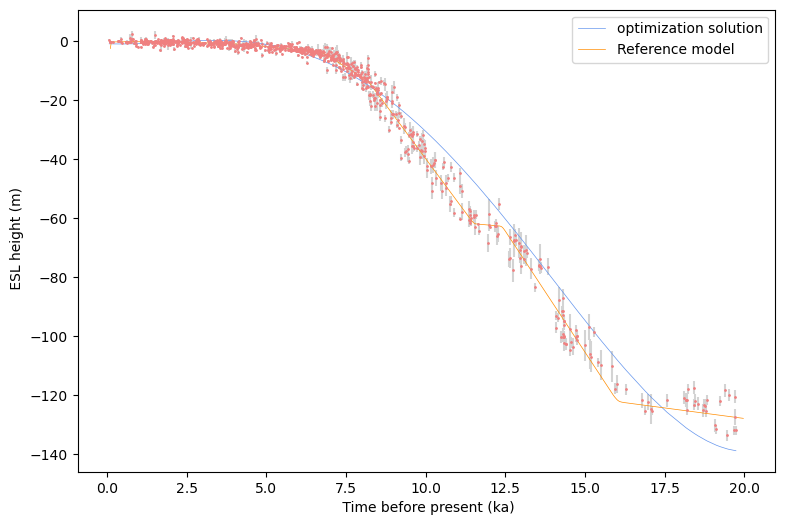

In [24]:
plot_data()
plot_model(data_x,jacobian(data_x).dot(inv_result_2.model), "optimization solution", color="cornflowerblue")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

The optimization fails to convergence for this problem (with default settings). 

-------

### Challenge - Change the polynomial degree

Try and replace the 3rd order polynomial with a 2nd order polynomial (i.e. $M=2$) by adding the required commands below. What does the plot looks like? 

Start from code below:

```
inv_problem = BaseProblem()
inv_problem.set_data(data_y)
inv_problem.set_jacobian(jacobian(n=<CHANGE ME>))
inv_problem.set_data_covariance_inv(Cd_inv())
inv_options.set_solving_method("matrix solvers") # lets decide to use a matrix solver.
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

print("Inferred curve with n = <CHANGE ME> ")
plot_data()
plot_model(data_x,jacobian(x,n=<CHANGE ME>).dot(inv_result.model), "optimization solution", color="cornflowerblue")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

```


In [25]:
# Copy the template above, Replace <CHANGE ME> with your answer



Inferred curve with n = 3 


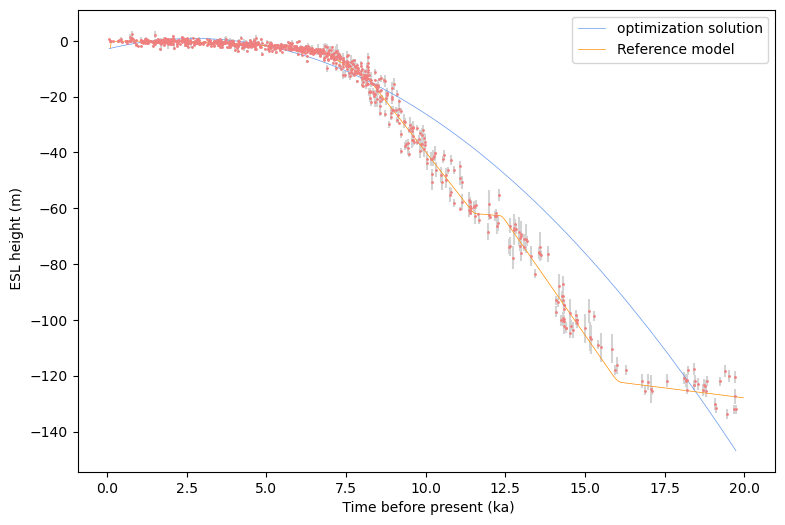

In [26]:
#@title Solution

inv_problem = BaseProblem()
inv_problem.set_data(data_y)
inv_problem.set_jacobian(jacobian(n=3))
inv_problem.set_data_covariance_inv(Cd_inv())
inv_options.set_solving_method("matrix solvers") # lets decide to use a matrix solver.
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

print("Inferred curve with n = 3 ")
plot_data()
plot_model(data_x,jacobian(data_x,n=3).dot(inv_result.model), "optimization solution", color="cornflowerblue")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

Changing to a second order polynomial does converge but gives a poor fit.

-------

## 3. Bayesian sampling


### Likelihood

Since data errors follow a Gaussian in this example, we can define a Likelihood function, $p({\mathbf d}_{obs}| {\mathbf m})$. 

$$
p({\mathbf d}_{obs} | {\mathbf m}) \propto \exp \left\{- \frac{1}{2} ({\mathbf d}_{obs}-{\mathbf d}_{pred}({\mathbf m}))^T C_D^{-1} ({\mathbf d}_{obs}-{\mathbf d}_{pred}({\mathbf m})) \right\}
$$

where ${\mathbf d}_{obs}$ represents the observed y values and ${\mathbf d}_{pred}({\mathbf m})$ are those predicted by the polynomial model $({\mathbf m})$. The Likelihood is defined as the probability of observing the data actually observed, given a model. In practice we usually only need to evaluate the log of the Likelihood, $\log p({\mathbf d}_{obs} | {\mathbf m})$.
To do so, we require the inverse data covariance matrix describing the statistics of the noise in the data, $C_D^{-1}$ . For this problem the data errors are independent with identical standard deviation in noise for each datum. Hence $C_D^{-1} = \frac{1}{\sigma^2}I$ where $\sigma=1$.

Here we artificially increase the observational errors on the data so that the spread of the posterior samples are visible.

In [27]:
Cdinv = Cd_inv()                 # inverse data covariance matrix

def log_likelihood(model):
    y_synthetics = forward(model)
    residual = data_y - y_synthetics
    return -0.5 * residual @ (Cdinv @ residual).T

Note that the user could specify **any appropriate Likelihood function** of their choosing here.

### Prior

Bayesian sampling requires a prior probability density function. A common problem with polynomial coefficients as model parameters is that it is not at all obvious what a prior should be. Here we choose a uniform prior with specified bounds

$$
\begin{align}
p({\mathbf m}) &= \frac{1}{V},\quad  l_i \le m_i \le u_i, \quad (i=1,\dots,M)\\
\\
         &= 0, \quad {\rm otherwise},
\end{align}
$$

where $l_i$ and $u_i$ are lower and upper bounds on the $i$th model coefficient.

Here use the uniform distribution with ${\mathbf l}^T = (-10.,-10.,-10.,-10.)$, and ${\mathbf u}^T = (10.,10.,10.,10.)$.

In [28]:
m_lower_bound = np.ones(nparams) * (-10.)             # lower bound for uniform prior
m_upper_bound = np.ones(nparams) * 10                 # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

Note that the user could specify **any appropriate Prior PDF** of their choosing here.

### Bayesian sampling

In this aproach we sample a probability distribution rather than find a single best fit solution. Bayes' theorem tells us the the posterior distribution is proportional to the Likelihood and the prior.

$$p(\mathbf{m}|\mathbf{d}) = K p(\mathbf{d}|\mathbf{m})p(\mathbf{m})$$

where $K$ is some constant. Under the assumptions specified $p(\mathbf{m}|\mathbf{d})$ gives a probability density of models that are supported by the data. We seek to draw random samples from $p(\mathbf{m}|\mathbf{d})$ over model space and then to make inferences from the resulting ensemble of model parameters.

In this example we make use of *The Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler*
[Goodman and Weare 2010](https://msp.org/camcos/2010/5-1/p04.xhtml) to sample the
posterior distribution of the model. (See more details about [emcee](https://emcee.readthedocs.io/en/stable/)).

### Starting points for random walkers

Now we define some hyperparameters (e.g. the number of walkers and steps), and initialise
the starting positions of walkers. We start all walkers in a small ball about a chosen point
$(0, 0, 0, 0)$.

In [29]:
nwalkers = 32
ndim = nparams
nsteps = 10000
walkers_start = np.zeros(nparams) + 1e-4 * np.random.randn(nwalkers, ndim)

### Add the information and run with CoFI

In [30]:
######## CoFI BaseProblem - provide additional information
inv_problem.set_log_prior(log_prior)
inv_problem.set_log_likelihood(log_likelihood)
inv_problem.set_model_shape(ndim)

######## CoFI InversionOptions - get a different tool
inv_options_3 = InversionOptions()
inv_options_3.set_tool("emcee")      # Here we use to Affine Invariant McMC sampler from Goodman and Weare (2010).
inv_options_3.set_params(nwalkers=nwalkers, nsteps=nsteps, progress=True, initial_state=walkers_start)

######## CoFI Inversion - run it
inv_3 = Inversion(inv_problem, inv_options_3)
inv_result_3 = inv_3.run()

######## CoFI InversionResult - check result
print(f"The inversion result from `emcee`:")
inv_result_3.summary()

  0%|                                                                                                                                                                                  | 0/10000 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                                       | 14/10000 [00:00<01:13, 135.23it/s]

  0%|▍                                                                                                                                                                       | 28/10000 [00:00<01:12, 136.89it/s]

  0%|▋                                                                                                                                                                       | 42/10000 [00:00<01:12, 137.47it/s]

  1%|▉                                                                                                                                                                       | 56/10000 [00:00<01:11, 138.22it/s]

  1%|█▏                                                                                                                                                                      | 70/10000 [00:00<01:11, 138.13it/s]

  1%|█▍                                                                                                                                                                      | 84/10000 [00:00<01:11, 138.50it/s]

  1%|█▋                                                                                                                                                                      | 98/10000 [00:00<01:11, 138.80it/s]

  1%|█▊                                                                                                                                                                     | 112/10000 [00:00<01:11, 139.02it/s]

  1%|██                                                                                                                                                                     | 126/10000 [00:00<01:10, 139.08it/s]

  1%|██▎                                                                                                                                                                    | 140/10000 [00:01<01:10, 139.12it/s]

  2%|██▌                                                                                                                                                                    | 154/10000 [00:01<01:10, 138.85it/s]

  2%|██▊                                                                                                                                                                    | 168/10000 [00:01<01:10, 138.97it/s]

  2%|███                                                                                                                                                                    | 182/10000 [00:01<01:10, 139.05it/s]

  2%|███▎                                                                                                                                                                   | 196/10000 [00:01<01:10, 139.16it/s]

  2%|███▌                                                                                                                                                                   | 210/10000 [00:01<01:10, 139.18it/s]

  2%|███▋                                                                                                                                                                   | 224/10000 [00:01<01:10, 139.27it/s]

  2%|███▉                                                                                                                                                                   | 238/10000 [00:01<01:10, 139.27it/s]

  3%|████▏                                                                                                                                                                  | 252/10000 [00:01<01:09, 139.34it/s]

  3%|████▍                                                                                                                                                                  | 266/10000 [00:01<01:09, 139.40it/s]

  3%|████▋                                                                                                                                                                  | 280/10000 [00:02<01:09, 139.50it/s]

  3%|████▉                                                                                                                                                                  | 294/10000 [00:02<01:10, 137.66it/s]

  3%|█████▏                                                                                                                                                                 | 308/10000 [00:02<01:10, 137.49it/s]

  3%|█████▍                                                                                                                                                                 | 322/10000 [00:02<01:10, 137.99it/s]

  3%|█████▌                                                                                                                                                                 | 336/10000 [00:02<01:09, 138.43it/s]

  4%|█████▊                                                                                                                                                                 | 350/10000 [00:02<01:09, 138.66it/s]

  4%|██████                                                                                                                                                                 | 364/10000 [00:02<01:09, 138.82it/s]

  4%|██████▎                                                                                                                                                                | 378/10000 [00:02<01:09, 137.80it/s]

  4%|██████▌                                                                                                                                                                | 392/10000 [00:02<01:09, 138.34it/s]

  4%|██████▊                                                                                                                                                                | 406/10000 [00:02<01:21, 118.14it/s]

  4%|██████▉                                                                                                                                                                | 419/10000 [00:03<01:19, 121.08it/s]

  4%|███████▏                                                                                                                                                               | 432/10000 [00:03<01:31, 104.28it/s]

  4%|███████▍                                                                                                                                                               | 446/10000 [00:03<01:25, 111.58it/s]

  5%|███████▋                                                                                                                                                               | 460/10000 [00:03<01:20, 118.37it/s]

  5%|███████▉                                                                                                                                                               | 474/10000 [00:03<01:16, 123.91it/s]

  5%|████████▏                                                                                                                                                              | 488/10000 [00:03<01:14, 128.14it/s]

  5%|████████▍                                                                                                                                                              | 502/10000 [00:03<01:12, 131.32it/s]

  5%|████████▌                                                                                                                                                              | 516/10000 [00:03<01:10, 133.72it/s]

  5%|████████▊                                                                                                                                                              | 530/10000 [00:03<01:10, 133.56it/s]

  5%|█████████                                                                                                                                                              | 544/10000 [00:04<01:09, 135.18it/s]

  6%|█████████▎                                                                                                                                                             | 558/10000 [00:04<01:09, 136.37it/s]

  6%|█████████▌                                                                                                                                                             | 572/10000 [00:04<01:08, 137.24it/s]

  6%|█████████▊                                                                                                                                                             | 586/10000 [00:04<01:08, 137.80it/s]

  6%|██████████                                                                                                                                                             | 600/10000 [00:04<01:08, 138.12it/s]

  6%|██████████▎                                                                                                                                                            | 614/10000 [00:04<01:07, 138.38it/s]

  6%|██████████▍                                                                                                                                                            | 628/10000 [00:04<01:07, 138.70it/s]

  6%|██████████▋                                                                                                                                                            | 642/10000 [00:04<01:07, 138.76it/s]

  7%|██████████▉                                                                                                                                                            | 656/10000 [00:04<01:07, 138.85it/s]

  7%|███████████▏                                                                                                                                                           | 670/10000 [00:04<01:07, 139.06it/s]

  7%|███████████▍                                                                                                                                                           | 684/10000 [00:05<01:07, 137.20it/s]

  7%|███████████▋                                                                                                                                                           | 698/10000 [00:05<01:07, 137.80it/s]

  7%|███████████▉                                                                                                                                                           | 712/10000 [00:05<01:07, 137.14it/s]

  7%|████████████                                                                                                                                                           | 726/10000 [00:05<01:07, 137.25it/s]

  7%|████████████▎                                                                                                                                                          | 740/10000 [00:05<01:07, 137.44it/s]

  8%|████████████▌                                                                                                                                                          | 754/10000 [00:05<01:07, 137.62it/s]

  8%|████████████▊                                                                                                                                                          | 768/10000 [00:05<01:07, 137.74it/s]

  8%|█████████████                                                                                                                                                          | 782/10000 [00:05<01:06, 137.94it/s]

  8%|█████████████▎                                                                                                                                                         | 796/10000 [00:05<01:06, 138.12it/s]

  8%|█████████████▌                                                                                                                                                         | 810/10000 [00:05<01:06, 138.22it/s]

  8%|█████████████▊                                                                                                                                                         | 824/10000 [00:06<01:06, 138.25it/s]

  8%|█████████████▉                                                                                                                                                         | 838/10000 [00:06<01:06, 138.48it/s]

  9%|██████████████▏                                                                                                                                                        | 852/10000 [00:06<01:05, 138.68it/s]

  9%|██████████████▍                                                                                                                                                        | 866/10000 [00:06<01:05, 138.56it/s]

  9%|██████████████▋                                                                                                                                                        | 880/10000 [00:06<01:05, 138.39it/s]

  9%|██████████████▉                                                                                                                                                        | 894/10000 [00:06<01:05, 138.60it/s]

  9%|███████████████▏                                                                                                                                                       | 908/10000 [00:06<01:05, 138.83it/s]

  9%|███████████████▍                                                                                                                                                       | 922/10000 [00:06<01:05, 138.96it/s]

  9%|███████████████▋                                                                                                                                                       | 936/10000 [00:06<01:05, 139.16it/s]

 10%|███████████████▊                                                                                                                                                       | 950/10000 [00:07<01:05, 139.18it/s]

 10%|████████████████                                                                                                                                                       | 964/10000 [00:07<01:04, 139.36it/s]

 10%|████████████████▎                                                                                                                                                      | 978/10000 [00:07<01:05, 138.51it/s]

 10%|████████████████▌                                                                                                                                                      | 992/10000 [00:07<01:05, 138.13it/s]

 10%|████████████████▋                                                                                                                                                     | 1006/10000 [00:07<01:05, 138.22it/s]

 10%|████████████████▉                                                                                                                                                     | 1020/10000 [00:07<01:04, 138.47it/s]

 10%|█████████████████▏                                                                                                                                                    | 1034/10000 [00:07<01:04, 138.77it/s]

 10%|█████████████████▍                                                                                                                                                    | 1048/10000 [00:07<01:04, 139.01it/s]

 11%|█████████████████▋                                                                                                                                                    | 1062/10000 [00:07<01:04, 139.08it/s]

 11%|█████████████████▊                                                                                                                                                    | 1076/10000 [00:07<01:04, 139.30it/s]

 11%|██████████████████                                                                                                                                                    | 1090/10000 [00:08<01:03, 139.47it/s]

 11%|██████████████████▎                                                                                                                                                   | 1104/10000 [00:08<01:04, 137.57it/s]

 11%|██████████████████▌                                                                                                                                                   | 1118/10000 [00:08<01:04, 137.55it/s]

 11%|██████████████████▊                                                                                                                                                   | 1132/10000 [00:08<01:04, 138.18it/s]

 11%|███████████████████                                                                                                                                                   | 1146/10000 [00:08<01:03, 138.59it/s]

 12%|███████████████████▎                                                                                                                                                  | 1160/10000 [00:08<01:03, 138.76it/s]

 12%|███████████████████▍                                                                                                                                                  | 1174/10000 [00:08<01:03, 138.07it/s]

 12%|███████████████████▋                                                                                                                                                  | 1188/10000 [00:08<01:03, 138.43it/s]

 12%|███████████████████▉                                                                                                                                                  | 1202/10000 [00:08<01:03, 138.75it/s]

 12%|████████████████████▏                                                                                                                                                 | 1216/10000 [00:08<01:03, 139.07it/s]

 12%|████████████████████▍                                                                                                                                                 | 1230/10000 [00:09<01:02, 139.30it/s]

 12%|████████████████████▋                                                                                                                                                 | 1244/10000 [00:09<01:02, 139.45it/s]

 13%|████████████████████▉                                                                                                                                                 | 1258/10000 [00:09<01:02, 139.48it/s]

 13%|█████████████████████                                                                                                                                                 | 1272/10000 [00:09<01:02, 139.51it/s]

 13%|█████████████████████▎                                                                                                                                                | 1286/10000 [00:09<01:02, 138.90it/s]

 13%|█████████████████████▌                                                                                                                                                | 1300/10000 [00:09<01:02, 138.84it/s]

 13%|█████████████████████▊                                                                                                                                                | 1314/10000 [00:09<01:02, 139.01it/s]

 13%|██████████████████████                                                                                                                                                | 1328/10000 [00:09<01:02, 139.22it/s]

 13%|██████████████████████▎                                                                                                                                               | 1342/10000 [00:09<01:02, 139.38it/s]

 14%|██████████████████████▌                                                                                                                                               | 1356/10000 [00:09<01:01, 139.45it/s]

 14%|██████████████████████▋                                                                                                                                               | 1370/10000 [00:10<01:01, 139.42it/s]

 14%|██████████████████████▉                                                                                                                                               | 1384/10000 [00:10<01:01, 139.36it/s]

 14%|███████████████████████▏                                                                                                                                              | 1398/10000 [00:10<01:01, 139.51it/s]

 14%|███████████████████████▍                                                                                                                                              | 1412/10000 [00:10<01:01, 139.60it/s]

 14%|███████████████████████▋                                                                                                                                              | 1426/10000 [00:10<01:01, 139.28it/s]

 14%|███████████████████████▉                                                                                                                                              | 1440/10000 [00:10<01:01, 138.22it/s]

 15%|████████████████████████▏                                                                                                                                             | 1454/10000 [00:10<01:02, 137.14it/s]

 15%|████████████████████████▎                                                                                                                                             | 1468/10000 [00:10<01:01, 137.78it/s]

 15%|████████████████████████▌                                                                                                                                             | 1482/10000 [00:10<01:02, 137.12it/s]

 15%|████████████████████████▊                                                                                                                                             | 1496/10000 [00:10<01:01, 137.58it/s]

 15%|█████████████████████████                                                                                                                                             | 1510/10000 [00:11<01:02, 135.17it/s]

 15%|█████████████████████████▎                                                                                                                                            | 1524/10000 [00:11<01:02, 136.33it/s]

 15%|█████████████████████████▌                                                                                                                                            | 1538/10000 [00:11<01:01, 137.22it/s]

 16%|█████████████████████████▊                                                                                                                                            | 1552/10000 [00:11<01:01, 137.91it/s]

 16%|█████████████████████████▉                                                                                                                                            | 1566/10000 [00:11<01:01, 138.02it/s]

 16%|██████████████████████████▏                                                                                                                                           | 1580/10000 [00:11<01:01, 137.57it/s]

 16%|██████████████████████████▍                                                                                                                                           | 1594/10000 [00:11<01:00, 138.12it/s]

 16%|██████████████████████████▋                                                                                                                                           | 1608/10000 [00:11<01:00, 138.46it/s]

 16%|██████████████████████████▉                                                                                                                                           | 1622/10000 [00:11<01:00, 138.78it/s]

 16%|███████████████████████████▏                                                                                                                                          | 1636/10000 [00:11<01:00, 138.98it/s]

 16%|███████████████████████████▍                                                                                                                                          | 1650/10000 [00:12<01:00, 138.72it/s]

 17%|███████████████████████████▌                                                                                                                                          | 1664/10000 [00:12<01:00, 138.86it/s]

 17%|███████████████████████████▊                                                                                                                                          | 1678/10000 [00:12<01:00, 138.26it/s]

 17%|████████████████████████████                                                                                                                                          | 1692/10000 [00:12<00:59, 138.47it/s]

 17%|████████████████████████████▎                                                                                                                                         | 1706/10000 [00:12<00:59, 138.67it/s]

 17%|████████████████████████████▌                                                                                                                                         | 1720/10000 [00:12<00:59, 138.42it/s]

 17%|████████████████████████████▊                                                                                                                                         | 1734/10000 [00:12<00:59, 138.63it/s]

 17%|█████████████████████████████                                                                                                                                         | 1748/10000 [00:12<01:00, 136.79it/s]

 18%|█████████████████████████████▏                                                                                                                                        | 1762/10000 [00:12<00:59, 137.60it/s]

 18%|█████████████████████████████▍                                                                                                                                        | 1776/10000 [00:12<00:59, 138.10it/s]

 18%|█████████████████████████████▋                                                                                                                                        | 1790/10000 [00:13<00:59, 138.48it/s]

 18%|█████████████████████████████▉                                                                                                                                        | 1804/10000 [00:13<00:59, 138.77it/s]

 18%|██████████████████████████████▏                                                                                                                                       | 1818/10000 [00:13<00:58, 139.05it/s]

 18%|██████████████████████████████▍                                                                                                                                       | 1832/10000 [00:13<00:58, 139.18it/s]

 18%|██████████████████████████████▋                                                                                                                                       | 1846/10000 [00:13<00:58, 139.09it/s]

 19%|██████████████████████████████▉                                                                                                                                       | 1860/10000 [00:13<00:58, 138.93it/s]

 19%|███████████████████████████████                                                                                                                                       | 1874/10000 [00:13<00:58, 139.14it/s]

 19%|███████████████████████████████▎                                                                                                                                      | 1888/10000 [00:13<00:58, 138.84it/s]

 19%|███████████████████████████████▌                                                                                                                                      | 1902/10000 [00:13<00:58, 138.79it/s]

 19%|███████████████████████████████▊                                                                                                                                      | 1916/10000 [00:13<00:58, 138.96it/s]

 19%|████████████████████████████████                                                                                                                                      | 1930/10000 [00:14<00:58, 137.22it/s]

 19%|████████████████████████████████▎                                                                                                                                     | 1944/10000 [00:14<00:58, 137.87it/s]

 20%|████████████████████████████████▌                                                                                                                                     | 1958/10000 [00:14<00:58, 138.37it/s]

 20%|████████████████████████████████▋                                                                                                                                     | 1972/10000 [00:14<00:57, 138.71it/s]

 20%|████████████████████████████████▉                                                                                                                                     | 1986/10000 [00:14<00:57, 138.51it/s]

 20%|█████████████████████████████████▏                                                                                                                                    | 2000/10000 [00:14<00:58, 137.69it/s]

 20%|█████████████████████████████████▍                                                                                                                                    | 2014/10000 [00:14<00:57, 138.21it/s]

 20%|█████████████████████████████████▋                                                                                                                                    | 2028/10000 [00:14<00:57, 138.61it/s]

 20%|█████████████████████████████████▉                                                                                                                                    | 2042/10000 [00:14<00:57, 138.88it/s]

 21%|██████████████████████████████████▏                                                                                                                                   | 2056/10000 [00:14<00:57, 139.08it/s]

 21%|██████████████████████████████████▎                                                                                                                                   | 2070/10000 [00:15<00:56, 139.22it/s]

 21%|██████████████████████████████████▌                                                                                                                                   | 2084/10000 [00:15<00:56, 139.31it/s]

 21%|██████████████████████████████████▊                                                                                                                                   | 2098/10000 [00:15<00:56, 139.32it/s]

 21%|███████████████████████████████████                                                                                                                                   | 2112/10000 [00:15<00:56, 139.40it/s]

 21%|███████████████████████████████████▎                                                                                                                                  | 2126/10000 [00:15<00:56, 138.46it/s]

 21%|███████████████████████████████████▌                                                                                                                                  | 2140/10000 [00:15<00:56, 138.44it/s]

 22%|███████████████████████████████████▊                                                                                                                                  | 2154/10000 [00:15<00:56, 138.75it/s]

 22%|███████████████████████████████████▉                                                                                                                                  | 2168/10000 [00:15<00:56, 138.85it/s]

 22%|████████████████████████████████████▏                                                                                                                                 | 2182/10000 [00:15<00:56, 139.01it/s]

 22%|████████████████████████████████████▍                                                                                                                                 | 2196/10000 [00:15<00:56, 139.14it/s]

 22%|████████████████████████████████████▋                                                                                                                                 | 2210/10000 [00:16<00:55, 139.12it/s]

 22%|████████████████████████████████████▉                                                                                                                                 | 2224/10000 [00:16<00:55, 139.13it/s]

 22%|█████████████████████████████████████▏                                                                                                                                | 2238/10000 [00:16<00:55, 139.30it/s]

 23%|█████████████████████████████████████▍                                                                                                                                | 2252/10000 [00:16<00:55, 139.37it/s]

 23%|█████████████████████████████████████▌                                                                                                                                | 2266/10000 [00:16<00:55, 139.16it/s]

 23%|█████████████████████████████████████▊                                                                                                                                | 2280/10000 [00:16<00:55, 139.12it/s]

 23%|██████████████████████████████████████                                                                                                                                | 2294/10000 [00:16<00:55, 139.15it/s]

 23%|██████████████████████████████████████▎                                                                                                                               | 2308/10000 [00:16<00:55, 139.24it/s]

 23%|██████████████████████████████████████▌                                                                                                                               | 2322/10000 [00:16<00:55, 139.35it/s]

 23%|██████████████████████████████████████▊                                                                                                                               | 2336/10000 [00:17<00:54, 139.40it/s]

 24%|███████████████████████████████████████                                                                                                                               | 2350/10000 [00:17<00:55, 137.21it/s]

 24%|███████████████████████████████████████▏                                                                                                                              | 2364/10000 [00:17<00:55, 137.10it/s]

 24%|███████████████████████████████████████▍                                                                                                                              | 2378/10000 [00:17<00:55, 137.70it/s]

 24%|███████████████████████████████████████▋                                                                                                                              | 2392/10000 [00:17<00:55, 138.22it/s]

 24%|███████████████████████████████████████▉                                                                                                                              | 2406/10000 [00:17<00:54, 138.32it/s]

 24%|████████████████████████████████████████▏                                                                                                                             | 2420/10000 [00:17<00:54, 138.58it/s]

 24%|████████████████████████████████████████▍                                                                                                                             | 2434/10000 [00:17<00:54, 138.72it/s]

 24%|████████████████████████████████████████▋                                                                                                                             | 2448/10000 [00:17<00:54, 138.92it/s]

 25%|████████████████████████████████████████▊                                                                                                                             | 2462/10000 [00:17<00:54, 139.11it/s]

 25%|█████████████████████████████████████████                                                                                                                             | 2476/10000 [00:18<00:54, 139.25it/s]

 25%|█████████████████████████████████████████▎                                                                                                                            | 2490/10000 [00:18<01:03, 119.04it/s]

 25%|█████████████████████████████████████████▌                                                                                                                            | 2504/10000 [00:18<01:00, 124.37it/s]

 25%|█████████████████████████████████████████▊                                                                                                                            | 2517/10000 [00:18<01:02, 118.85it/s]

 25%|██████████████████████████████████████████                                                                                                                            | 2531/10000 [00:18<01:00, 123.66it/s]

 25%|██████████████████████████████████████████▏                                                                                                                           | 2545/10000 [00:18<00:58, 127.14it/s]

 26%|██████████████████████████████████████████▍                                                                                                                           | 2559/10000 [00:18<00:56, 130.64it/s]

 26%|██████████████████████████████████████████▋                                                                                                                           | 2573/10000 [00:18<00:55, 133.12it/s]

 26%|██████████████████████████████████████████▉                                                                                                                           | 2587/10000 [00:18<00:54, 134.96it/s]

 26%|███████████████████████████████████████████▏                                                                                                                          | 2601/10000 [00:19<00:54, 136.24it/s]

 26%|███████████████████████████████████████████▍                                                                                                                          | 2615/10000 [00:19<00:53, 137.20it/s]

 26%|███████████████████████████████████████████▋                                                                                                                          | 2629/10000 [00:19<00:54, 135.82it/s]

 26%|███████████████████████████████████████████▊                                                                                                                          | 2643/10000 [00:19<00:53, 136.92it/s]

 27%|████████████████████████████████████████████                                                                                                                          | 2657/10000 [00:19<00:53, 137.66it/s]

 27%|████████████████████████████████████████████▎                                                                                                                         | 2671/10000 [00:19<00:53, 137.98it/s]

 27%|████████████████████████████████████████████▌                                                                                                                         | 2685/10000 [00:19<00:53, 137.76it/s]

 27%|████████████████████████████████████████████▊                                                                                                                         | 2699/10000 [00:19<00:52, 138.24it/s]

 27%|█████████████████████████████████████████████                                                                                                                         | 2713/10000 [00:19<00:52, 138.56it/s]

 27%|█████████████████████████████████████████████▎                                                                                                                        | 2727/10000 [00:19<00:52, 138.94it/s]

 27%|█████████████████████████████████████████████▌                                                                                                                        | 2741/10000 [00:20<00:52, 138.97it/s]

 28%|█████████████████████████████████████████████▋                                                                                                                        | 2755/10000 [00:20<00:52, 136.99it/s]

 28%|█████████████████████████████████████████████▉                                                                                                                        | 2769/10000 [00:20<00:52, 137.68it/s]

 28%|██████████████████████████████████████████████▏                                                                                                                       | 2783/10000 [00:20<00:52, 138.19it/s]

 28%|██████████████████████████████████████████████▍                                                                                                                       | 2797/10000 [00:20<00:52, 137.49it/s]

 28%|██████████████████████████████████████████████▋                                                                                                                       | 2811/10000 [00:20<00:52, 137.80it/s]

 28%|██████████████████████████████████████████████▉                                                                                                                       | 2825/10000 [00:20<00:51, 138.04it/s]

 28%|███████████████████████████████████████████████▏                                                                                                                      | 2839/10000 [00:20<00:51, 137.77it/s]

 29%|███████████████████████████████████████████████▎                                                                                                                      | 2853/10000 [00:20<00:51, 137.77it/s]

 29%|███████████████████████████████████████████████▌                                                                                                                      | 2867/10000 [00:20<00:51, 137.76it/s]

 29%|███████████████████████████████████████████████▊                                                                                                                      | 2881/10000 [00:21<00:51, 137.84it/s]

 29%|████████████████████████████████████████████████                                                                                                                      | 2895/10000 [00:21<00:51, 137.80it/s]

 29%|████████████████████████████████████████████████▎                                                                                                                     | 2909/10000 [00:21<00:51, 137.74it/s]

 29%|████████████████████████████████████████████████▌                                                                                                                     | 2923/10000 [00:21<00:51, 137.86it/s]

 29%|████████████████████████████████████████████████▊                                                                                                                     | 2937/10000 [00:21<00:51, 137.83it/s]

 30%|████████████████████████████████████████████████▉                                                                                                                     | 2951/10000 [00:21<00:51, 137.67it/s]

 30%|█████████████████████████████████████████████████▏                                                                                                                    | 2965/10000 [00:21<00:51, 137.63it/s]

 30%|█████████████████████████████████████████████████▍                                                                                                                    | 2979/10000 [00:21<00:51, 137.63it/s]

 30%|█████████████████████████████████████████████████▋                                                                                                                    | 2993/10000 [00:21<00:50, 137.65it/s]

 30%|█████████████████████████████████████████████████▉                                                                                                                    | 3007/10000 [00:21<00:50, 137.73it/s]

 30%|██████████████████████████████████████████████████▏                                                                                                                   | 3021/10000 [00:22<00:50, 137.78it/s]

 30%|██████████████████████████████████████████████████▍                                                                                                                   | 3035/10000 [00:22<00:50, 137.94it/s]

 30%|██████████████████████████████████████████████████▌                                                                                                                   | 3049/10000 [00:22<00:50, 137.53it/s]

 31%|██████████████████████████████████████████████████▊                                                                                                                   | 3063/10000 [00:22<00:50, 137.70it/s]

 31%|███████████████████████████████████████████████████                                                                                                                   | 3077/10000 [00:22<00:50, 137.70it/s]

 31%|███████████████████████████████████████████████████▎                                                                                                                  | 3091/10000 [00:22<00:50, 137.65it/s]

 31%|███████████████████████████████████████████████████▌                                                                                                                  | 3105/10000 [00:22<00:50, 137.72it/s]

 31%|███████████████████████████████████████████████████▊                                                                                                                  | 3119/10000 [00:22<00:49, 137.89it/s]

 31%|████████████████████████████████████████████████████                                                                                                                  | 3133/10000 [00:22<00:49, 138.13it/s]

 31%|████████████████████████████████████████████████████▏                                                                                                                 | 3147/10000 [00:22<00:49, 138.31it/s]

 32%|████████████████████████████████████████████████████▍                                                                                                                 | 3161/10000 [00:23<00:50, 136.62it/s]

 32%|████████████████████████████████████████████████████▋                                                                                                                 | 3175/10000 [00:23<00:49, 136.69it/s]

 32%|████████████████████████████████████████████████████▉                                                                                                                 | 3189/10000 [00:23<00:49, 137.10it/s]

 32%|█████████████████████████████████████████████████████▏                                                                                                                | 3203/10000 [00:23<00:49, 137.75it/s]

 32%|█████████████████████████████████████████████████████▍                                                                                                                | 3217/10000 [00:23<00:49, 137.88it/s]

 32%|█████████████████████████████████████████████████████▋                                                                                                                | 3231/10000 [00:23<00:49, 137.23it/s]

 32%|█████████████████████████████████████████████████████▊                                                                                                                | 3245/10000 [00:23<00:49, 137.26it/s]

 33%|██████████████████████████████████████████████████████                                                                                                                | 3259/10000 [00:23<00:48, 137.73it/s]

 33%|██████████████████████████████████████████████████████▎                                                                                                               | 3273/10000 [00:23<00:48, 138.19it/s]

 33%|██████████████████████████████████████████████████████▌                                                                                                               | 3287/10000 [00:23<00:48, 138.48it/s]

 33%|██████████████████████████████████████████████████████▊                                                                                                               | 3301/10000 [00:24<00:48, 138.56it/s]

 33%|███████████████████████████████████████████████████████                                                                                                               | 3315/10000 [00:24<00:48, 138.72it/s]

 33%|███████████████████████████████████████████████████████▎                                                                                                              | 3329/10000 [00:24<00:48, 138.60it/s]

 33%|███████████████████████████████████████████████████████▍                                                                                                              | 3343/10000 [00:24<00:48, 138.04it/s]

 34%|███████████████████████████████████████████████████████▋                                                                                                              | 3357/10000 [00:24<00:48, 137.83it/s]

 34%|███████████████████████████████████████████████████████▉                                                                                                              | 3371/10000 [00:24<00:48, 137.17it/s]

 34%|████████████████████████████████████████████████████████▏                                                                                                             | 3385/10000 [00:24<00:48, 136.79it/s]

 34%|████████████████████████████████████████████████████████▍                                                                                                             | 3399/10000 [00:24<00:48, 137.42it/s]

 34%|████████████████████████████████████████████████████████▋                                                                                                             | 3413/10000 [00:24<00:48, 136.16it/s]

 34%|████████████████████████████████████████████████████████▉                                                                                                             | 3427/10000 [00:24<00:48, 136.85it/s]

 34%|█████████████████████████████████████████████████████████                                                                                                             | 3441/10000 [00:25<00:47, 137.26it/s]

 35%|█████████████████████████████████████████████████████████▎                                                                                                            | 3455/10000 [00:25<00:47, 136.87it/s]

 35%|█████████████████████████████████████████████████████████▌                                                                                                            | 3469/10000 [00:25<00:47, 137.49it/s]

 35%|█████████████████████████████████████████████████████████▊                                                                                                            | 3483/10000 [00:25<00:47, 137.34it/s]

 35%|██████████████████████████████████████████████████████████                                                                                                            | 3497/10000 [00:25<00:47, 137.50it/s]

 35%|██████████████████████████████████████████████████████████▎                                                                                                           | 3511/10000 [00:25<00:47, 137.86it/s]

 35%|██████████████████████████████████████████████████████████▌                                                                                                           | 3525/10000 [00:25<00:46, 138.28it/s]

 35%|██████████████████████████████████████████████████████████▋                                                                                                           | 3539/10000 [00:25<00:46, 138.54it/s]

 36%|██████████████████████████████████████████████████████████▉                                                                                                           | 3553/10000 [00:25<00:46, 138.71it/s]

 36%|███████████████████████████████████████████████████████████▏                                                                                                          | 3567/10000 [00:26<00:46, 138.87it/s]

 36%|███████████████████████████████████████████████████████████▍                                                                                                          | 3581/10000 [00:26<00:46, 136.66it/s]

 36%|███████████████████████████████████████████████████████████▋                                                                                                          | 3595/10000 [00:26<00:46, 137.44it/s]

 36%|███████████████████████████████████████████████████████████▉                                                                                                          | 3609/10000 [00:26<00:46, 137.95it/s]

 36%|████████████████████████████████████████████████████████████▏                                                                                                         | 3623/10000 [00:26<00:46, 138.28it/s]

 36%|████████████████████████████████████████████████████████████▎                                                                                                         | 3637/10000 [00:26<00:45, 138.40it/s]

 37%|████████████████████████████████████████████████████████████▌                                                                                                         | 3651/10000 [00:26<00:45, 138.59it/s]

 37%|████████████████████████████████████████████████████████████▊                                                                                                         | 3665/10000 [00:26<00:45, 138.78it/s]

 37%|█████████████████████████████████████████████████████████████                                                                                                         | 3679/10000 [00:26<00:45, 138.85it/s]

 37%|█████████████████████████████████████████████████████████████▎                                                                                                        | 3693/10000 [00:26<00:45, 138.91it/s]

 37%|█████████████████████████████████████████████████████████████▌                                                                                                        | 3707/10000 [00:27<00:45, 139.12it/s]

 37%|█████████████████████████████████████████████████████████████▊                                                                                                        | 3721/10000 [00:27<00:45, 139.15it/s]

 37%|██████████████████████████████████████████████████████████████                                                                                                        | 3735/10000 [00:27<00:45, 138.46it/s]

 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 3749/10000 [00:27<00:45, 138.36it/s]

 38%|██████████████████████████████████████████████████████████████▍                                                                                                       | 3763/10000 [00:27<00:45, 138.00it/s]

 38%|██████████████████████████████████████████████████████████████▋                                                                                                       | 3777/10000 [00:27<00:45, 137.87it/s]

 38%|██████████████████████████████████████████████████████████████▉                                                                                                       | 3791/10000 [00:27<00:45, 137.38it/s]

 38%|███████████████████████████████████████████████████████████████▏                                                                                                      | 3805/10000 [00:27<00:45, 137.47it/s]

 38%|███████████████████████████████████████████████████████████████▍                                                                                                      | 3819/10000 [00:27<00:44, 137.67it/s]

 38%|███████████████████████████████████████████████████████████████▋                                                                                                      | 3833/10000 [00:27<00:44, 137.83it/s]

 38%|███████████████████████████████████████████████████████████████▊                                                                                                      | 3847/10000 [00:28<00:44, 137.96it/s]

 39%|████████████████████████████████████████████████████████████████                                                                                                      | 3861/10000 [00:28<00:44, 138.04it/s]

 39%|████████████████████████████████████████████████████████████████▎                                                                                                     | 3875/10000 [00:28<00:44, 138.09it/s]

 39%|████████████████████████████████████████████████████████████████▌                                                                                                     | 3889/10000 [00:28<00:44, 138.20it/s]

 39%|████████████████████████████████████████████████████████████████▊                                                                                                     | 3903/10000 [00:28<00:44, 137.58it/s]

 39%|█████████████████████████████████████████████████████████████████                                                                                                     | 3917/10000 [00:28<00:44, 137.31it/s]

 39%|█████████████████████████████████████████████████████████████████▎                                                                                                    | 3931/10000 [00:28<00:44, 136.65it/s]

 39%|█████████████████████████████████████████████████████████████████▍                                                                                                    | 3945/10000 [00:28<00:44, 135.09it/s]

 40%|█████████████████████████████████████████████████████████████████▋                                                                                                    | 3959/10000 [00:28<00:44, 135.93it/s]

 40%|█████████████████████████████████████████████████████████████████▉                                                                                                    | 3973/10000 [00:28<00:44, 136.49it/s]

 40%|██████████████████████████████████████████████████████████████████▏                                                                                                   | 3987/10000 [00:29<00:44, 135.19it/s]

 40%|██████████████████████████████████████████████████████████████████▍                                                                                                   | 4001/10000 [00:29<00:44, 136.06it/s]

 40%|██████████████████████████████████████████████████████████████████▋                                                                                                   | 4015/10000 [00:29<00:43, 136.59it/s]

 40%|██████████████████████████████████████████████████████████████████▉                                                                                                   | 4029/10000 [00:29<00:43, 137.06it/s]

 40%|███████████████████████████████████████████████████████████████████                                                                                                   | 4043/10000 [00:29<00:43, 137.28it/s]

 41%|███████████████████████████████████████████████████████████████████▎                                                                                                  | 4057/10000 [00:29<00:43, 137.39it/s]

 41%|███████████████████████████████████████████████████████████████████▌                                                                                                  | 4071/10000 [00:29<00:43, 137.51it/s]

 41%|███████████████████████████████████████████████████████████████████▊                                                                                                  | 4085/10000 [00:29<00:42, 137.72it/s]

 41%|████████████████████████████████████████████████████████████████████                                                                                                  | 4099/10000 [00:29<00:42, 137.87it/s]

 41%|████████████████████████████████████████████████████████████████████▎                                                                                                 | 4113/10000 [00:30<00:48, 120.51it/s]

 41%|████████████████████████████████████████████████████████████████████▌                                                                                                 | 4127/10000 [00:30<00:46, 125.26it/s]

 41%|████████████████████████████████████████████████████████████████████▋                                                                                                 | 4141/10000 [00:30<00:45, 128.86it/s]

 42%|████████████████████████████████████████████████████████████████████▉                                                                                                 | 4155/10000 [00:30<00:44, 131.38it/s]

 42%|█████████████████████████████████████████████████████████████████████▏                                                                                                | 4169/10000 [00:30<00:43, 133.00it/s]

 42%|█████████████████████████████████████████████████████████████████████▍                                                                                                | 4183/10000 [00:30<00:43, 134.33it/s]

 42%|█████████████████████████████████████████████████████████████████████▋                                                                                                | 4197/10000 [00:30<00:42, 135.33it/s]

 42%|█████████████████████████████████████████████████████████████████████▉                                                                                                | 4211/10000 [00:30<00:42, 136.18it/s]

 42%|██████████████████████████████████████████████████████████████████████▏                                                                                               | 4225/10000 [00:30<00:42, 136.81it/s]

 42%|██████████████████████████████████████████████████████████████████████▎                                                                                               | 4239/10000 [00:30<00:42, 137.13it/s]

 43%|██████████████████████████████████████████████████████████████████████▌                                                                                               | 4253/10000 [00:31<00:41, 137.36it/s]

 43%|██████████████████████████████████████████████████████████████████████▊                                                                                               | 4267/10000 [00:31<00:41, 137.46it/s]

 43%|███████████████████████████████████████████████████████████████████████                                                                                               | 4281/10000 [00:31<00:41, 137.63it/s]

 43%|███████████████████████████████████████████████████████████████████████▎                                                                                              | 4295/10000 [00:31<00:41, 137.87it/s]

 43%|███████████████████████████████████████████████████████████████████████▌                                                                                              | 4309/10000 [00:31<00:41, 137.77it/s]

 43%|███████████████████████████████████████████████████████████████████████▊                                                                                              | 4323/10000 [00:31<00:41, 137.75it/s]

 43%|███████████████████████████████████████████████████████████████████████▉                                                                                              | 4337/10000 [00:31<00:41, 137.76it/s]

 44%|████████████████████████████████████████████████████████████████████████▏                                                                                             | 4351/10000 [00:31<00:40, 137.80it/s]

 44%|████████████████████████████████████████████████████████████████████████▍                                                                                             | 4365/10000 [00:31<00:40, 137.99it/s]

 44%|████████████████████████████████████████████████████████████████████████▋                                                                                             | 4379/10000 [00:31<00:40, 138.01it/s]

 44%|████████████████████████████████████████████████████████████████████████▉                                                                                             | 4393/10000 [00:32<00:41, 136.35it/s]

 44%|█████████████████████████████████████████████████████████████████████████▏                                                                                            | 4407/10000 [00:32<00:40, 136.89it/s]

 44%|█████████████████████████████████████████████████████████████████████████▍                                                                                            | 4421/10000 [00:32<00:40, 136.56it/s]

 44%|█████████████████████████████████████████████████████████████████████████▌                                                                                            | 4435/10000 [00:32<00:40, 136.76it/s]

 44%|█████████████████████████████████████████████████████████████████████████▊                                                                                            | 4449/10000 [00:32<00:40, 137.11it/s]

 45%|██████████████████████████████████████████████████████████████████████████                                                                                            | 4463/10000 [00:32<00:40, 137.30it/s]

 45%|██████████████████████████████████████████████████████████████████████████▎                                                                                           | 4477/10000 [00:32<00:40, 135.48it/s]

 45%|██████████████████████████████████████████████████████████████████████████▌                                                                                           | 4491/10000 [00:32<00:40, 136.25it/s]

 45%|██████████████████████████████████████████████████████████████████████████▊                                                                                           | 4505/10000 [00:32<00:40, 136.80it/s]

 45%|███████████████████████████████████████████████████████████████████████████                                                                                           | 4519/10000 [00:32<00:39, 137.13it/s]

 45%|███████████████████████████████████████████████████████████████████████████▏                                                                                          | 4533/10000 [00:33<00:39, 137.51it/s]

 45%|███████████████████████████████████████████████████████████████████████████▍                                                                                          | 4547/10000 [00:33<00:39, 137.70it/s]

 46%|███████████████████████████████████████████████████████████████████████████▋                                                                                          | 4561/10000 [00:33<00:39, 137.94it/s]

 46%|███████████████████████████████████████████████████████████████████████████▉                                                                                          | 4575/10000 [00:33<00:39, 138.04it/s]

 46%|████████████████████████████████████████████████████████████████████████████▏                                                                                         | 4589/10000 [00:33<00:39, 137.97it/s]

 46%|████████████████████████████████████████████████████████████████████████████▍                                                                                         | 4603/10000 [00:33<00:39, 137.96it/s]

 46%|████████████████████████████████████████████████████████████████████████████▋                                                                                         | 4617/10000 [00:33<00:39, 138.02it/s]

 46%|████████████████████████████████████████████████████████████████████████████▊                                                                                         | 4631/10000 [00:33<00:38, 137.98it/s]

 46%|█████████████████████████████████████████████████████████████████████████████                                                                                         | 4645/10000 [00:33<00:38, 138.04it/s]

 47%|█████████████████████████████████████████████████████████████████████████████▎                                                                                        | 4659/10000 [00:33<00:38, 138.13it/s]

 47%|█████████████████████████████████████████████████████████████████████████████▌                                                                                        | 4673/10000 [00:34<00:38, 138.22it/s]

 47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                        | 4687/10000 [00:34<00:38, 138.17it/s]

 47%|██████████████████████████████████████████████████████████████████████████████                                                                                        | 4701/10000 [00:34<00:38, 138.22it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                       | 4715/10000 [00:34<00:38, 138.21it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▌                                                                                       | 4729/10000 [00:34<00:38, 138.18it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▋                                                                                       | 4743/10000 [00:34<00:38, 137.95it/s]

 48%|██████████████████████████████████████████████████████████████████████████████▉                                                                                       | 4757/10000 [00:34<00:38, 137.94it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▏                                                                                      | 4771/10000 [00:34<00:37, 137.97it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▍                                                                                      | 4785/10000 [00:34<00:37, 137.98it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▋                                                                                      | 4799/10000 [00:35<00:37, 138.03it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▉                                                                                      | 4813/10000 [00:35<00:38, 136.39it/s]

 48%|████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 4827/10000 [00:35<00:37, 136.90it/s]

 48%|████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 4841/10000 [00:35<00:37, 137.29it/s]

 49%|████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 4855/10000 [00:35<00:37, 137.53it/s]

 49%|████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 4869/10000 [00:35<00:37, 137.46it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████                                                                                     | 4883/10000 [00:35<00:37, 137.31it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 4897/10000 [00:35<00:37, 137.36it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 4911/10000 [00:35<00:36, 137.65it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 4925/10000 [00:35<00:36, 137.67it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 4939/10000 [00:36<00:36, 137.64it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 4953/10000 [00:36<00:36, 137.75it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 4967/10000 [00:36<00:36, 136.46it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 4981/10000 [00:36<00:36, 137.11it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 4995/10000 [00:36<00:36, 137.59it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 5009/10000 [00:36<00:36, 137.24it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 5023/10000 [00:36<00:36, 137.65it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 5037/10000 [00:36<00:35, 138.01it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 5051/10000 [00:36<00:35, 138.24it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████                                                                                  | 5065/10000 [00:36<00:35, 138.49it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 5079/10000 [00:37<00:35, 138.50it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 5093/10000 [00:37<00:35, 138.65it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 5107/10000 [00:37<00:35, 137.91it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████                                                                                 | 5121/10000 [00:37<00:35, 138.08it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 5135/10000 [00:37<00:35, 137.48it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 5149/10000 [00:37<00:35, 137.35it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 5163/10000 [00:37<00:35, 137.38it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 5177/10000 [00:37<00:35, 137.12it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 5191/10000 [00:37<00:34, 137.71it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 5205/10000 [00:37<00:34, 137.63it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 5219/10000 [00:38<00:35, 136.37it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 5233/10000 [00:38<00:34, 137.03it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████                                                                               | 5247/10000 [00:38<00:34, 137.43it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 5261/10000 [00:38<00:34, 137.81it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 5275/10000 [00:38<00:34, 138.11it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 5289/10000 [00:38<00:34, 138.36it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████                                                                              | 5303/10000 [00:38<00:34, 137.66it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 5317/10000 [00:38<00:33, 137.98it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 5331/10000 [00:38<00:33, 138.16it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 5345/10000 [00:38<00:33, 138.41it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 5359/10000 [00:39<00:33, 138.54it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 5373/10000 [00:39<00:34, 134.03it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 5387/10000 [00:39<00:34, 135.35it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 5401/10000 [00:39<00:33, 136.39it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 5415/10000 [00:39<00:33, 136.84it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████                                                                            | 5429/10000 [00:39<00:33, 137.36it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 5443/10000 [00:39<00:33, 137.80it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 5457/10000 [00:39<00:32, 138.06it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 5471/10000 [00:39<00:32, 138.28it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████                                                                           | 5485/10000 [00:39<00:32, 138.39it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 5499/10000 [00:40<00:32, 138.48it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 5513/10000 [00:40<00:32, 138.41it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 5527/10000 [00:40<00:32, 138.06it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 5541/10000 [00:40<00:32, 137.67it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 5555/10000 [00:40<00:32, 137.82it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 5569/10000 [00:40<00:32, 138.05it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 5583/10000 [00:40<00:31, 138.22it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 5597/10000 [00:40<00:31, 138.27it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 5611/10000 [00:40<00:31, 138.44it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 5625/10000 [00:41<00:31, 138.50it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 5639/10000 [00:41<00:31, 136.48it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 5653/10000 [00:41<00:31, 137.23it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 5667/10000 [00:41<00:31, 137.71it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 5681/10000 [00:41<00:31, 137.93it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 5695/10000 [00:41<00:31, 137.88it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 5709/10000 [00:41<00:31, 137.53it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 5723/10000 [00:41<00:31, 137.78it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 5737/10000 [00:41<00:30, 138.03it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 5751/10000 [00:41<00:30, 138.27it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 5765/10000 [00:42<00:30, 138.20it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 5779/10000 [00:42<00:30, 138.39it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 5793/10000 [00:42<00:30, 137.97it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 5807/10000 [00:42<00:30, 138.22it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 5821/10000 [00:42<00:30, 138.40it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 5835/10000 [00:42<00:30, 138.37it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 5849/10000 [00:42<00:30, 138.35it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 5863/10000 [00:42<00:29, 138.37it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 5877/10000 [00:42<00:29, 138.46it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 5891/10000 [00:42<00:29, 138.65it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 5905/10000 [00:43<00:29, 138.72it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 5919/10000 [00:43<00:29, 138.73it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 5933/10000 [00:43<00:29, 138.72it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 5947/10000 [00:43<00:29, 138.69it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 5961/10000 [00:43<00:29, 138.71it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 5975/10000 [00:43<00:29, 138.55it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 5989/10000 [00:43<00:28, 138.50it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 6003/10000 [00:43<00:28, 138.63it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 6017/10000 [00:43<00:28, 138.70it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 6031/10000 [00:43<00:28, 138.72it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 6045/10000 [00:44<00:28, 137.00it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 6059/10000 [00:44<00:28, 137.52it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 6073/10000 [00:44<00:28, 137.80it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 6087/10000 [00:44<00:28, 138.08it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 6101/10000 [00:44<00:28, 138.27it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 6115/10000 [00:44<00:28, 138.21it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 6129/10000 [00:44<00:28, 138.23it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 6143/10000 [00:44<00:28, 137.70it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 6157/10000 [00:44<00:27, 138.11it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 6171/10000 [00:44<00:27, 138.48it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 6185/10000 [00:45<00:27, 138.75it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 6199/10000 [00:45<00:27, 138.90it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 6213/10000 [00:45<00:27, 139.10it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 6227/10000 [00:45<00:27, 139.24it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 6241/10000 [00:45<00:26, 139.36it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 6255/10000 [00:45<00:26, 139.25it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 6269/10000 [00:45<00:26, 139.21it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 6283/10000 [00:45<00:26, 139.39it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 6297/10000 [00:45<00:26, 139.50it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 6311/10000 [00:45<00:26, 139.53it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 6325/10000 [00:46<00:26, 139.55it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 6339/10000 [00:46<00:26, 139.57it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 6353/10000 [00:46<00:26, 139.60it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 6367/10000 [00:46<00:26, 139.59it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 6381/10000 [00:46<00:25, 139.59it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 6395/10000 [00:46<00:25, 139.51it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 6409/10000 [00:46<00:25, 139.50it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 6423/10000 [00:46<00:25, 139.44it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 6437/10000 [00:46<00:25, 139.45it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 6451/10000 [00:46<00:25, 139.54it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 6465/10000 [00:47<00:25, 137.83it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 6479/10000 [00:47<00:25, 138.34it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 6493/10000 [00:47<00:25, 138.06it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 6507/10000 [00:47<00:25, 138.44it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 6521/10000 [00:47<00:25, 138.50it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 6535/10000 [00:47<00:25, 138.47it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 6549/10000 [00:47<00:24, 138.79it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 6563/10000 [00:47<00:24, 138.95it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 6577/10000 [00:47<00:24, 139.19it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 6591/10000 [00:47<00:24, 139.29it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 6605/10000 [00:48<00:24, 139.41it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 6619/10000 [00:48<00:24, 139.49it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 6633/10000 [00:48<00:24, 139.58it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 6647/10000 [00:48<00:24, 139.55it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 6661/10000 [00:48<00:23, 139.48it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 6675/10000 [00:48<00:23, 139.25it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 6689/10000 [00:48<00:23, 138.50it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 6703/10000 [00:48<00:23, 138.79it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 6717/10000 [00:48<00:23, 139.09it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 6731/10000 [00:48<00:23, 139.16it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 6745/10000 [00:49<00:23, 139.26it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 6759/10000 [00:49<00:23, 139.34it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 6773/10000 [00:49<00:23, 139.29it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 6787/10000 [00:49<00:23, 139.32it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 6801/10000 [00:49<00:22, 139.15it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 6815/10000 [00:49<00:22, 139.15it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 6829/10000 [00:49<00:22, 139.19it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 6843/10000 [00:49<00:22, 139.29it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 6857/10000 [00:49<00:22, 139.30it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 6871/10000 [00:49<00:22, 139.34it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 6885/10000 [00:50<00:22, 137.43it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 6899/10000 [00:50<00:22, 138.03it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 6913/10000 [00:50<00:22, 138.44it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 6927/10000 [00:50<00:22, 138.70it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 6941/10000 [00:50<00:22, 138.21it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 6955/10000 [00:50<00:21, 138.49it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 6969/10000 [00:50<00:21, 138.63it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 6983/10000 [00:50<00:21, 138.87it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 6997/10000 [00:50<00:21, 139.05it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 7011/10000 [00:51<00:21, 139.16it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 7025/10000 [00:51<00:21, 139.23it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 7039/10000 [00:51<00:21, 139.31it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 7053/10000 [00:51<00:21, 139.35it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 7067/10000 [00:51<00:21, 139.38it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 7081/10000 [00:51<00:20, 139.18it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 7095/10000 [00:51<00:20, 139.18it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 7109/10000 [00:51<00:20, 139.23it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 7123/10000 [00:51<00:20, 139.31it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 7137/10000 [00:51<00:20, 139.18it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 7151/10000 [00:52<00:20, 139.28it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 7165/10000 [00:52<00:20, 139.17it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 7179/10000 [00:52<00:20, 137.76it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 7193/10000 [00:52<00:20, 138.15it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 7207/10000 [00:52<00:20, 138.53it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 7221/10000 [00:52<00:20, 138.65it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 7235/10000 [00:52<00:19, 138.87it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 7249/10000 [00:52<00:19, 138.98it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 7263/10000 [00:52<00:19, 139.05it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 7277/10000 [00:52<00:19, 139.12it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 7291/10000 [00:53<00:19, 139.18it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 7305/10000 [00:53<00:19, 136.67it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 7319/10000 [00:53<00:19, 137.46it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 7333/10000 [00:53<00:19, 136.25it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 7347/10000 [00:53<00:19, 137.15it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 7361/10000 [00:53<00:19, 137.63it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 7375/10000 [00:53<00:19, 136.45it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 7389/10000 [00:53<00:19, 137.36it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 7403/10000 [00:53<00:18, 137.51it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 7417/10000 [00:53<00:18, 137.99it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 7431/10000 [00:54<00:18, 138.48it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 7445/10000 [00:54<00:18, 138.02it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 7459/10000 [00:54<00:18, 138.38it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 7473/10000 [00:54<00:18, 138.53it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 7487/10000 [00:54<00:18, 138.74it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 7501/10000 [00:54<00:18, 138.73it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 7515/10000 [00:54<00:17, 138.80it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 7529/10000 [00:54<00:17, 138.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 7543/10000 [00:54<00:17, 138.74it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 7557/10000 [00:54<00:17, 138.91it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 7571/10000 [00:55<00:17, 138.96it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 7585/10000 [00:55<00:17, 139.16it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 7599/10000 [00:55<00:17, 139.17it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 7613/10000 [00:55<00:17, 139.13it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 7627/10000 [00:55<00:17, 139.06it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 7641/10000 [00:55<00:16, 138.95it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 7655/10000 [00:55<00:16, 138.72it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 7669/10000 [00:55<00:19, 116.87it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 7683/10000 [00:55<00:19, 121.92it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 7697/10000 [00:56<00:18, 126.67it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 7711/10000 [00:56<00:17, 128.00it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 7725/10000 [00:56<00:17, 131.03it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 7739/10000 [00:56<00:16, 133.52it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 7753/10000 [00:56<00:16, 134.51it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 7767/10000 [00:56<00:16, 135.27it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 7781/10000 [00:56<00:16, 136.33it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 7795/10000 [00:56<00:16, 137.23it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 7809/10000 [00:56<00:15, 137.93it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 7823/10000 [00:56<00:15, 138.42it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 7837/10000 [00:57<00:15, 138.77it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 7851/10000 [00:57<00:15, 138.30it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 7865/10000 [00:57<00:15, 137.89it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 7879/10000 [00:57<00:15, 138.35it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 7893/10000 [00:57<00:15, 138.61it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 7907/10000 [00:57<00:15, 137.59it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 7921/10000 [00:57<00:15, 137.85it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 7935/10000 [00:57<00:14, 138.28it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 7949/10000 [00:57<00:14, 137.82it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 7963/10000 [00:57<00:14, 138.37it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 7977/10000 [00:58<00:14, 138.54it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 7991/10000 [00:58<00:15, 130.17it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 8005/10000 [00:58<00:15, 131.10it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 8019/10000 [00:58<00:15, 130.73it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 8033/10000 [00:58<00:14, 133.24it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 8047/10000 [00:58<00:14, 134.79it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 8061/10000 [00:58<00:14, 135.15it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 8075/10000 [00:58<00:14, 136.46it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 8089/10000 [00:58<00:13, 137.39it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 8103/10000 [00:58<00:13, 138.12it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 8117/10000 [00:59<00:13, 136.80it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 8131/10000 [00:59<00:13, 137.43it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 8145/10000 [00:59<00:13, 138.00it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 8159/10000 [00:59<00:13, 138.53it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 8173/10000 [00:59<00:13, 138.71it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 8187/10000 [00:59<00:13, 138.93it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 8201/10000 [00:59<00:12, 139.12it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 8215/10000 [00:59<00:12, 139.19it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 8229/10000 [00:59<00:12, 139.34it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 8243/10000 [00:59<00:12, 139.39it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 8257/10000 [01:00<00:15, 116.13it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 8271/10000 [01:00<00:14, 120.58it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 8285/10000 [01:00<00:13, 125.71it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 8299/10000 [01:00<00:13, 129.31it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 8313/10000 [01:00<00:12, 131.84it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 8327/10000 [01:00<00:12, 134.01it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 8341/10000 [01:00<00:12, 135.55it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 8356/10000 [01:00<00:12, 136.94it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 8370/10000 [01:00<00:11, 137.69it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 8384/10000 [01:01<00:11, 137.21it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 8398/10000 [01:01<00:12, 125.51it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 8411/10000 [01:01<00:12, 123.30it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 8425/10000 [01:01<00:12, 126.76it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 8439/10000 [01:01<00:11, 130.26it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 8453/10000 [01:01<00:11, 132.74it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 8467/10000 [01:01<00:11, 134.72it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 8481/10000 [01:01<00:11, 136.03it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 8495/10000 [01:01<00:10, 137.12it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 8509/10000 [01:02<00:10, 137.84it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 8523/10000 [01:02<00:10, 136.53it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 8537/10000 [01:02<00:10, 136.72it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 8551/10000 [01:02<00:10, 137.59it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 8565/10000 [01:02<00:10, 138.13it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 8579/10000 [01:02<00:10, 138.43it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 8593/10000 [01:02<00:10, 138.44it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 8607/10000 [01:02<00:10, 138.77it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 8621/10000 [01:02<00:09, 138.96it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 8635/10000 [01:02<00:09, 139.21it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 8649/10000 [01:03<00:09, 139.44it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 8663/10000 [01:03<00:09, 139.54it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 8677/10000 [01:03<00:09, 139.44it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 8691/10000 [01:03<00:09, 139.55it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 8705/10000 [01:03<00:09, 139.64it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 8719/10000 [01:03<00:09, 139.60it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 8733/10000 [01:03<00:09, 139.63it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 8747/10000 [01:03<00:08, 139.58it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 8761/10000 [01:03<00:08, 139.55it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 8775/10000 [01:03<00:08, 139.52it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 8789/10000 [01:04<00:08, 139.28it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 8804/10000 [01:04<00:08, 139.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 8818/10000 [01:04<00:08, 139.44it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 8832/10000 [01:04<00:08, 139.52it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 8846/10000 [01:04<00:08, 138.87it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 8860/10000 [01:04<00:08, 138.42it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 8874/10000 [01:04<00:08, 138.57it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 8888/10000 [01:04<00:08, 138.90it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 8902/10000 [01:04<00:07, 139.13it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 8916/10000 [01:04<00:07, 139.38it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 8930/10000 [01:05<00:07, 137.64it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 8944/10000 [01:05<00:07, 138.17it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 8958/10000 [01:05<00:07, 138.61it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 8972/10000 [01:05<00:07, 138.97it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 8986/10000 [01:05<00:07, 139.02it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 9000/10000 [01:05<00:07, 139.06it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 9014/10000 [01:05<00:07, 139.17it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 9028/10000 [01:05<00:06, 139.19it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 9043/10000 [01:05<00:06, 139.47it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 9057/10000 [01:05<00:06, 139.58it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 9071/10000 [01:06<00:06, 139.53it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 9085/10000 [01:06<00:06, 139.63it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 9099/10000 [01:06<00:06, 139.59it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 9114/10000 [01:06<00:06, 139.73it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 9128/10000 [01:06<00:06, 139.80it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 9142/10000 [01:06<00:06, 139.65it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 9157/10000 [01:06<00:06, 139.79it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 9172/10000 [01:06<00:05, 139.92it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9186/10000 [01:06<00:05, 139.94it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 9201/10000 [01:07<00:05, 140.01it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 9216/10000 [01:07<00:05, 140.00it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 9230/10000 [01:07<00:05, 139.21it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 9245/10000 [01:07<00:05, 139.51it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 9260/10000 [01:07<00:05, 139.75it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 9274/10000 [01:07<00:05, 139.69it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 9288/10000 [01:07<00:05, 139.75it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 9302/10000 [01:07<00:04, 139.82it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 9316/10000 [01:07<00:04, 139.83it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9330/10000 [01:07<00:04, 139.59it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 9344/10000 [01:08<00:04, 139.45it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 9358/10000 [01:08<00:04, 137.85it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 9372/10000 [01:08<00:04, 138.42it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 9387/10000 [01:08<00:04, 138.97it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 9402/10000 [01:08<00:04, 139.33it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 9417/10000 [01:08<00:04, 139.64it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 9431/10000 [01:08<00:04, 138.94it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 9446/10000 [01:08<00:03, 139.36it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 9461/10000 [01:08<00:03, 139.65it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 9475/10000 [01:08<00:03, 139.70it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 9490/10000 [01:09<00:03, 139.89it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 9504/10000 [01:09<00:03, 139.91it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 9518/10000 [01:09<00:03, 139.33it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 9532/10000 [01:09<00:03, 139.39it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 9546/10000 [01:09<00:03, 139.55it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 9560/10000 [01:09<00:03, 139.51it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 9575/10000 [01:09<00:03, 139.73it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 9589/10000 [01:09<00:02, 139.79it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 9603/10000 [01:09<00:02, 139.74it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 9617/10000 [01:09<00:02, 139.18it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 9631/10000 [01:10<00:02, 138.80it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 9646/10000 [01:10<00:02, 139.22it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 9660/10000 [01:10<00:02, 139.43it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 9675/10000 [01:10<00:02, 139.66it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 9689/10000 [01:10<00:02, 139.34it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 9703/10000 [01:10<00:02, 138.44it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 9717/10000 [01:10<00:02, 138.71it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 9732/10000 [01:10<00:01, 139.15it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 9747/10000 [01:10<00:01, 139.50it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 9762/10000 [01:11<00:01, 139.75it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 9776/10000 [01:11<00:01, 138.04it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 9791/10000 [01:11<00:01, 138.69it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 9805/10000 [01:11<00:01, 139.04it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 9820/10000 [01:11<00:01, 139.37it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 9834/10000 [01:11<00:01, 139.32it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 9849/10000 [01:11<00:01, 139.57it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 9864/10000 [01:11<00:00, 139.81it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 9879/10000 [01:11<00:00, 139.94it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 9894/10000 [01:11<00:00, 140.00it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 9909/10000 [01:12<00:00, 140.03it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 9924/10000 [01:12<00:00, 140.07it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 9939/10000 [01:12<00:00, 139.38it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 9953/10000 [01:12<00:00, 138.74it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 9967/10000 [01:12<00:00, 138.87it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 9981/10000 [01:12<00:00, 139.18it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 9995/10000 [01:12<00:00, 139.40it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:12<00:00, 137.48it/s]

The inversion result from `emcee`:
Summary for inversion result
SUCCESS
----------------------------
sampler: <emcee.ensemble.EnsembleSampler object>
blob_names: ['log_likelihood', 'log_prior']


### Post-sampling analysis

By default the raw sampler resulting object is attached to `cofi`'s inversion result.

Optionally, you can convert that into an `arviz` data structure to have access to
a range of analysis functions. (See more details in [arviz documentation](https://python.arviz.org/en/latest/index.html)).

In [31]:
import arviz as az

labels = ["m0", "m1", "m2","m3","m4"]

sampler = inv_result_3.sampler
az_idata = az.from_emcee(sampler, var_names=labels)
# az_idata = inv_result_3.to_arviz()      # alternatively

In [32]:
az_idata.get("posterior")

<xarray.Dataset>
Dimensions:  (chain: 32, draw: 10000)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 9993 9994 9995 9996 9997 9998 9999
Data variables:
    m0       (chain, draw) float64 -3.307e-05 -3.307e-05 ... 1.718 1.69
    m1       (chain, draw) float64 -4.522e-05 -4.522e-05 ... -3.338 -3.309
    m2       (chain, draw) float64 -0.0001608 -0.0001608 ... 1.447 1.44
    m3       (chain, draw) float64 -0.0001509 -0.0001509 ... -0.209 -0.2084
    m4       (chain, draw) float64 9.485e-05 9.485e-05 ... 0.006418 0.006408
Attributes:
    created_at:                 2023-07-27T00:40:44.777398
    arviz_version:              0.15.1
    inference_library:          emcee
    inference_library_version:  3.1.4

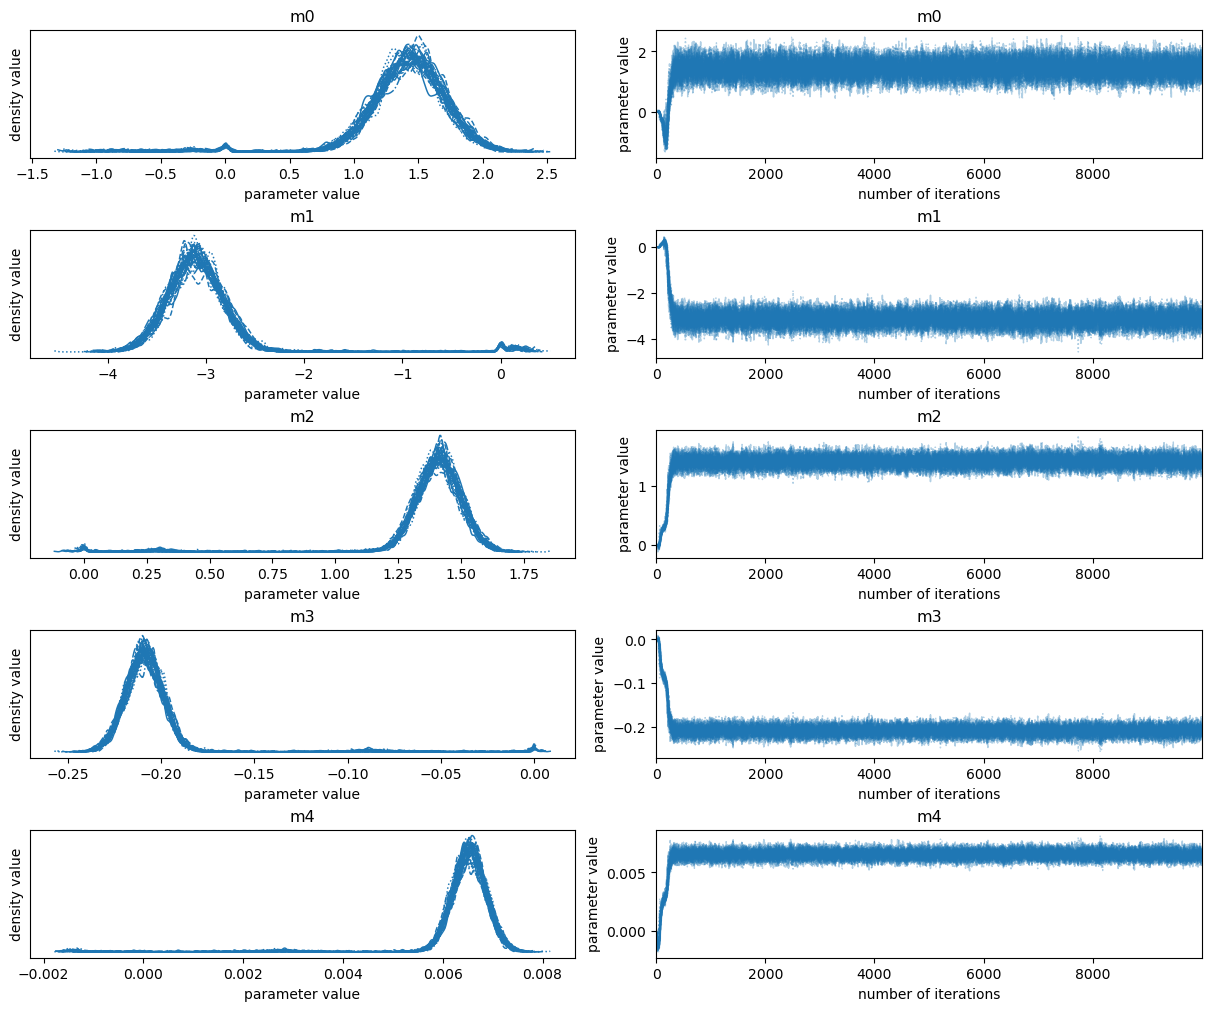

In [33]:
# a standard `trace` plot
axes = az.plot_trace(az_idata, backend_kwargs={"constrained_layout":True}); 

# add legends
for i, axes_pair in enumerate(axes):
    ax1 = axes_pair[0]
    ax2 = axes_pair[1]
    #ax1.axvline(true_model[i], linestyle='dotted', color='red')
    ax1.set_xlabel("parameter value")
    ax1.set_ylabel("density value")
    ax2.set_xlabel("number of iterations")
    ax2.set_ylabel("parameter value")

In [34]:
#tau = sampler.get_autocorr_time()
#print(f"autocorrelation time: {tau}")

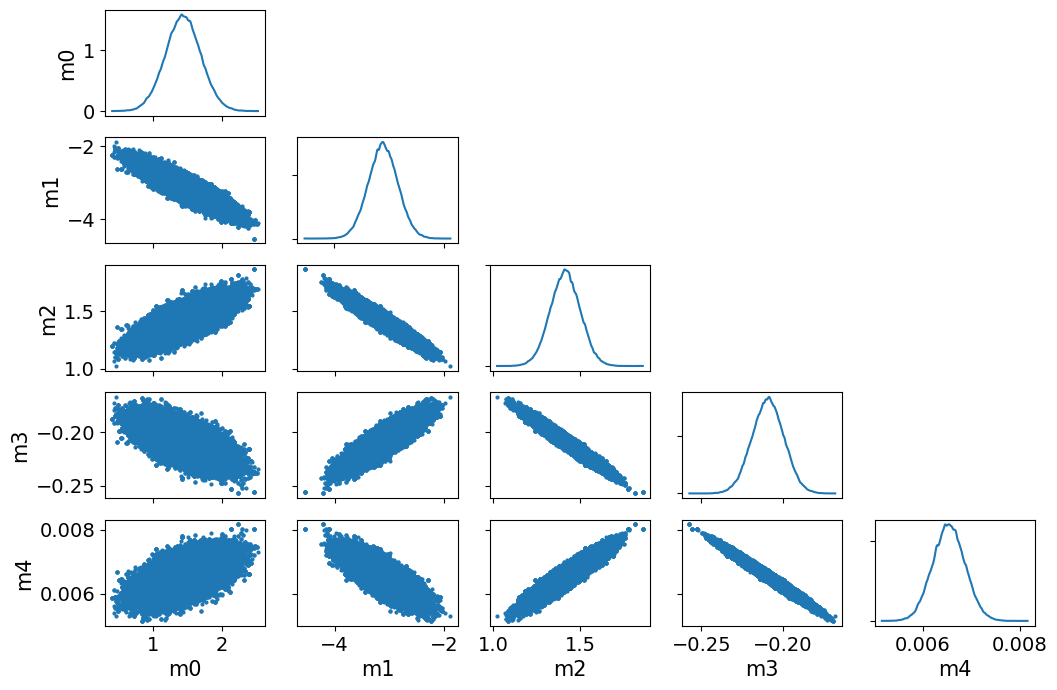

In [35]:
# a Corner plot

fig, axes = plt.subplots(nparams, nparams, figsize=(12,8))

if(True): # if we are plotting the model ensemble use this
    az.plot_pair(
        az_idata.sel(draw=slice(300,None)), 
        marginals=True, 
        #reference_values=dict(zip([f"m{i}" for i in range(4)], true_model.tolist())),
        ax=axes,
    );
else: # if we wish to plot a kernel density plot then use this option
    az.plot_pair(
        az_idata.sel(draw=slice(300,None)), 
        marginals=True, 
        #reference_values=dict(zip([f"m{i}" for i in range(4)], true_model.tolist())),
        kind="kde",
        kde_kwargs={
            "hdi_probs": [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
            "contourf_kwargs": {"cmap": "Blues"},
        },
        ax=axes,
    );

Now we plot the predicted curves for the posterior ensemble of solutions.

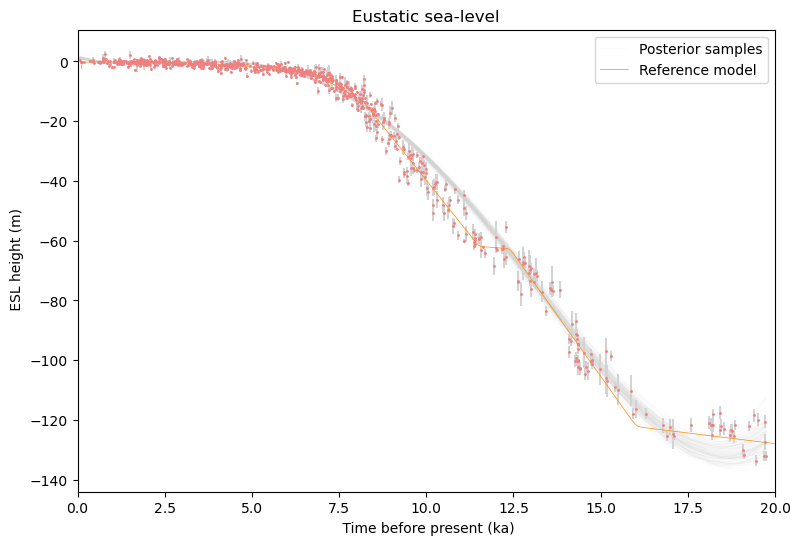

In [36]:
flat_samples = sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

plot_data(title="Eustatic sea-level")
plt.xlim(0,maxtime)
plot_models(flat_samples[inds],color="lightgrey")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")
#plt.xlim(15,20.)
#plt.ylim(-140,-100)

#### Expected values, credible intervals and model covariance matrix from the ensemble

In [37]:
print("\n Expected value and 95% credible intervals ")
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [5, 50, 95])
    print(" {} {:7.3f} [{:7.3f}, {:7.3f}]".format(labels[i],mcmc[1],mcmc[0],mcmc[2]))


 Expected value and 95% credible intervals 
 m0   1.438 [  1.022,   1.866]
 m1  -3.112 [ -3.554,  -2.670]
 m2   1.412 [  1.273,   1.552]
 m3  -0.209 [ -0.225,  -0.193]
 m4   0.007 [  0.006,   0.007]


In [38]:
CMpost = np.cov(flat_samples.T)
CM_std= np.std(flat_samples,axis=0)
print('Posterior model covariance matrix\n',CMpost)
print('\n Posterior estimate of model standard deviations in each parameter')
for i in range(ndim):
    print("    {} {:7.4f}".format(labels[i],CM_std[i]))

Posterior model covariance matrix
 [[ 6.54599239e-02 -6.13321628e-02  1.62953469e-02 -1.56538464e-03
   4.64306632e-05]
 [-6.13321628e-02  7.30863081e-02 -2.20237531e-02  2.29131086e-03
  -7.11401223e-05]
 [ 1.62953469e-02 -2.20237531e-02  7.31492058e-03 -8.15807116e-04
   2.63867524e-05]
 [-1.56538464e-03  2.29131086e-03 -8.15807116e-04  9.60837783e-05
  -3.21441761e-06]
 [ 4.64306632e-05 -7.11401223e-05  2.63867524e-05 -3.21441761e-06
   1.10403933e-07]]

 Posterior estimate of model standard deviations in each parameter
    m0  0.2558
    m1  0.2703
    m2  0.0855
    m3  0.0098
    m4  0.0003


---------

### Challenge - Change the prior model bounds

Replace the previous prior bounds to new values

The original  uniform bounds had  

${\mathbf l}^T = (-10.,-10.,-10.,-10.)$, and ${\mathbf u}^T = (10.,10.,10.,10.)$.

Lets replace with

${\mathbf l}^T = (-0.5,-10.,-10.,-10.)$, and ${\mathbf u}^T = (0.5,10.,10.,10.)$.

We have only changed the bounds of the first parameter. However since the true value of constant term was 6, these bounds are now inconsistent with the true model.

What does this do to the posterior distribution?

Start from the code template below:

```
m_lower_bound = <CHANGE ME>             # lower bound for uniform prior
m_upper_bound = <CHANGE ME>             # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

######## CoFI BaseProblem - update information
inv_problem.set_log_prior(log_prior)

######## CoFI Inversion - run it
inv_4 = Inversion(inv_problem, inv_options_3)
inv_result_4 = inv_4.run()

flat_samples = inv_result_4.sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

print("Resulting samples with prior model lower bounds of <CHANGE ME>, upper bounds of <CHANGE ME>")
plot_data()
plot_models(flat_samples[inds])
plot_model(x, true_y, "True model", color="darkorange")
```

In [39]:
# Copy the template above, Replace <CHANGE ME> with your answer



  0%|                                                                                                                                                                                  | 0/10000 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                                       | 14/10000 [00:00<01:12, 137.89it/s]

  0%|▍                                                                                                                                                                       | 28/10000 [00:00<01:12, 137.59it/s]

  0%|▋                                                                                                                                                                       | 42/10000 [00:00<01:12, 137.82it/s]

  1%|▉                                                                                                                                                                       | 56/10000 [00:00<01:11, 138.28it/s]

  1%|█▏                                                                                                                                                                      | 70/10000 [00:00<01:11, 138.22it/s]

  1%|█▍                                                                                                                                                                      | 84/10000 [00:00<01:11, 138.36it/s]

  1%|█▋                                                                                                                                                                      | 98/10000 [00:00<01:11, 138.52it/s]

  1%|█▊                                                                                                                                                                     | 112/10000 [00:00<01:11, 137.76it/s]

  1%|██                                                                                                                                                                     | 126/10000 [00:00<01:11, 138.05it/s]

  1%|██▎                                                                                                                                                                    | 140/10000 [00:01<01:11, 138.30it/s]

  2%|██▌                                                                                                                                                                    | 154/10000 [00:01<01:11, 138.38it/s]

  2%|██▊                                                                                                                                                                    | 168/10000 [00:01<01:10, 138.49it/s]

  2%|███                                                                                                                                                                    | 182/10000 [00:01<01:10, 138.55it/s]

  2%|███▎                                                                                                                                                                   | 196/10000 [00:01<01:10, 138.68it/s]

  2%|███▌                                                                                                                                                                   | 210/10000 [00:01<01:10, 138.74it/s]

  2%|███▋                                                                                                                                                                   | 224/10000 [00:01<01:11, 137.03it/s]

  2%|███▉                                                                                                                                                                   | 238/10000 [00:01<01:10, 137.52it/s]

  3%|████▏                                                                                                                                                                  | 253/10000 [00:01<01:09, 139.29it/s]

  3%|████▍                                                                                                                                                                  | 269/10000 [00:01<01:08, 142.97it/s]

  3%|████▋                                                                                                                                                                  | 284/10000 [00:02<01:07, 144.98it/s]

  3%|█████                                                                                                                                                                  | 300/10000 [00:02<01:05, 147.52it/s]

  3%|█████▎                                                                                                                                                                 | 316/10000 [00:02<01:04, 150.47it/s]

  3%|█████▌                                                                                                                                                                 | 332/10000 [00:02<01:03, 151.96it/s]

  3%|█████▊                                                                                                                                                                 | 348/10000 [00:02<01:14, 129.82it/s]

  4%|██████                                                                                                                                                                 | 364/10000 [00:02<01:11, 135.36it/s]

  4%|██████▎                                                                                                                                                                | 380/10000 [00:02<01:08, 139.96it/s]

  4%|██████▌                                                                                                                                                                | 396/10000 [00:02<01:06, 144.42it/s]

  4%|██████▉                                                                                                                                                                | 412/10000 [00:02<01:05, 146.81it/s]

  4%|███████▏                                                                                                                                                               | 428/10000 [00:03<01:04, 149.33it/s]

  4%|███████▍                                                                                                                                                               | 444/10000 [00:03<01:03, 150.15it/s]

  5%|███████▋                                                                                                                                                               | 460/10000 [00:03<01:02, 151.58it/s]

  5%|███████▉                                                                                                                                                               | 476/10000 [00:03<01:01, 153.82it/s]

  5%|████████▏                                                                                                                                                              | 492/10000 [00:03<01:12, 131.75it/s]

  5%|████████▍                                                                                                                                                              | 508/10000 [00:03<01:08, 137.67it/s]

  5%|████████▊                                                                                                                                                              | 524/10000 [00:03<01:06, 143.39it/s]

  5%|█████████                                                                                                                                                              | 540/10000 [00:03<01:04, 146.37it/s]

  6%|█████████▎                                                                                                                                                             | 556/10000 [00:03<01:03, 147.79it/s]

  6%|█████████▌                                                                                                                                                             | 571/10000 [00:04<01:03, 147.59it/s]

  6%|█████████▊                                                                                                                                                             | 587/10000 [00:04<01:02, 150.14it/s]

  6%|██████████                                                                                                                                                             | 603/10000 [00:04<01:01, 152.68it/s]

  6%|██████████▎                                                                                                                                                            | 619/10000 [00:04<01:00, 154.21it/s]

  6%|██████████▌                                                                                                                                                            | 635/10000 [00:04<01:00, 154.84it/s]

  7%|██████████▊                                                                                                                                                            | 651/10000 [00:04<01:01, 153.09it/s]

  7%|███████████▏                                                                                                                                                           | 667/10000 [00:04<01:02, 150.30it/s]

  7%|███████████▍                                                                                                                                                           | 683/10000 [00:04<01:01, 151.12it/s]

  7%|███████████▋                                                                                                                                                           | 699/10000 [00:04<01:01, 152.44it/s]

  7%|███████████▉                                                                                                                                                           | 715/10000 [00:04<01:00, 152.50it/s]

  7%|████████████▏                                                                                                                                                          | 731/10000 [00:05<01:00, 152.57it/s]

  7%|████████████▍                                                                                                                                                          | 747/10000 [00:05<01:00, 152.30it/s]

  8%|████████████▋                                                                                                                                                          | 763/10000 [00:05<01:00, 152.78it/s]

  8%|█████████████                                                                                                                                                          | 779/10000 [00:05<01:00, 152.73it/s]

  8%|█████████████▎                                                                                                                                                         | 795/10000 [00:05<00:59, 153.62it/s]

  8%|█████████████▌                                                                                                                                                         | 811/10000 [00:05<00:59, 153.30it/s]

  8%|█████████████▊                                                                                                                                                         | 827/10000 [00:05<00:59, 153.87it/s]

  8%|██████████████                                                                                                                                                         | 843/10000 [00:05<00:59, 153.20it/s]

  9%|██████████████▎                                                                                                                                                        | 859/10000 [00:05<00:59, 153.59it/s]

  9%|██████████████▌                                                                                                                                                        | 875/10000 [00:05<00:59, 154.25it/s]

  9%|██████████████▉                                                                                                                                                        | 891/10000 [00:06<00:59, 154.34it/s]

  9%|███████████████▏                                                                                                                                                       | 907/10000 [00:06<00:58, 155.38it/s]

  9%|███████████████▍                                                                                                                                                       | 923/10000 [00:06<00:58, 155.21it/s]

  9%|███████████████▋                                                                                                                                                       | 939/10000 [00:06<00:58, 154.94it/s]

 10%|███████████████▉                                                                                                                                                       | 955/10000 [00:06<00:58, 154.47it/s]

 10%|████████████████▏                                                                                                                                                      | 971/10000 [00:06<00:58, 154.92it/s]

 10%|████████████████▍                                                                                                                                                      | 987/10000 [00:06<00:58, 154.86it/s]

 10%|████████████████▋                                                                                                                                                     | 1003/10000 [00:06<00:58, 153.61it/s]

 10%|████████████████▉                                                                                                                                                     | 1019/10000 [00:06<00:58, 154.46it/s]

 10%|█████████████████▏                                                                                                                                                    | 1035/10000 [00:07<00:57, 154.83it/s]

 11%|█████████████████▍                                                                                                                                                    | 1051/10000 [00:07<00:57, 154.63it/s]

 11%|█████████████████▋                                                                                                                                                    | 1067/10000 [00:07<00:59, 151.40it/s]

 11%|█████████████████▉                                                                                                                                                    | 1083/10000 [00:07<00:58, 151.99it/s]

 11%|██████████████████▏                                                                                                                                                   | 1099/10000 [00:07<00:58, 152.07it/s]

 11%|██████████████████▌                                                                                                                                                   | 1115/10000 [00:07<00:58, 152.85it/s]

 11%|██████████████████▊                                                                                                                                                   | 1131/10000 [00:07<00:58, 152.07it/s]

 11%|███████████████████                                                                                                                                                   | 1147/10000 [00:07<00:58, 151.25it/s]

 12%|███████████████████▎                                                                                                                                                  | 1163/10000 [00:07<00:58, 151.47it/s]

 12%|███████████████████▌                                                                                                                                                  | 1179/10000 [00:07<00:58, 152.07it/s]

 12%|███████████████████▊                                                                                                                                                  | 1195/10000 [00:08<00:57, 152.79it/s]

 12%|████████████████████                                                                                                                                                  | 1211/10000 [00:08<00:57, 152.24it/s]

 12%|████████████████████▎                                                                                                                                                 | 1227/10000 [00:08<00:57, 152.49it/s]

 12%|████████████████████▋                                                                                                                                                 | 1243/10000 [00:08<00:57, 153.19it/s]

 13%|████████████████████▉                                                                                                                                                 | 1259/10000 [00:08<00:56, 154.16it/s]

 13%|█████████████████████▏                                                                                                                                                | 1275/10000 [00:08<00:56, 155.26it/s]

 13%|█████████████████████▍                                                                                                                                                | 1291/10000 [00:08<00:56, 155.13it/s]

 13%|█████████████████████▋                                                                                                                                                | 1307/10000 [00:08<00:56, 155.10it/s]

 13%|█████████████████████▉                                                                                                                                                | 1323/10000 [00:08<00:55, 155.98it/s]

 13%|██████████████████████▏                                                                                                                                               | 1339/10000 [00:09<00:55, 155.64it/s]

 14%|██████████████████████▍                                                                                                                                               | 1355/10000 [00:09<00:55, 155.84it/s]

 14%|██████████████████████▊                                                                                                                                               | 1371/10000 [00:09<00:55, 154.93it/s]

 14%|███████████████████████                                                                                                                                               | 1387/10000 [00:09<00:55, 154.79it/s]

 14%|███████████████████████▎                                                                                                                                              | 1403/10000 [00:09<00:55, 154.07it/s]

 14%|███████████████████████▌                                                                                                                                              | 1419/10000 [00:09<00:55, 154.84it/s]

 14%|███████████████████████▊                                                                                                                                              | 1435/10000 [00:09<00:55, 154.56it/s]

 15%|████████████████████████                                                                                                                                              | 1451/10000 [00:09<00:55, 154.23it/s]

 15%|████████████████████████▎                                                                                                                                             | 1467/10000 [00:09<00:55, 155.08it/s]

 15%|████████████████████████▋                                                                                                                                             | 1484/10000 [00:09<00:54, 157.29it/s]

 15%|████████████████████████▉                                                                                                                                             | 1501/10000 [00:10<00:53, 158.50it/s]

 15%|█████████████████████████▏                                                                                                                                            | 1517/10000 [00:10<00:53, 157.67it/s]

 15%|█████████████████████████▍                                                                                                                                            | 1533/10000 [00:10<00:53, 157.75it/s]

 16%|█████████████████████████▋                                                                                                                                            | 1550/10000 [00:10<00:53, 158.38it/s]

 16%|██████████████████████████                                                                                                                                            | 1567/10000 [00:10<00:52, 159.16it/s]

 16%|██████████████████████████▎                                                                                                                                           | 1583/10000 [00:10<00:53, 156.67it/s]

 16%|██████████████████████████▌                                                                                                                                           | 1599/10000 [00:10<00:54, 155.22it/s]

 16%|██████████████████████████▊                                                                                                                                           | 1615/10000 [00:10<00:54, 155.05it/s]

 16%|███████████████████████████                                                                                                                                           | 1631/10000 [00:10<00:54, 154.73it/s]

 16%|███████████████████████████▎                                                                                                                                          | 1647/10000 [00:10<00:53, 155.26it/s]

 17%|███████████████████████████▌                                                                                                                                          | 1663/10000 [00:11<00:53, 155.57it/s]

 17%|███████████████████████████▊                                                                                                                                          | 1679/10000 [00:11<00:53, 154.29it/s]

 17%|████████████████████████████▏                                                                                                                                         | 1695/10000 [00:11<00:53, 154.27it/s]

 17%|████████████████████████████▍                                                                                                                                         | 1711/10000 [00:11<00:54, 153.29it/s]

 17%|████████████████████████████▋                                                                                                                                         | 1727/10000 [00:11<00:53, 153.50it/s]

 17%|████████████████████████████▉                                                                                                                                         | 1743/10000 [00:11<00:53, 153.92it/s]

 18%|█████████████████████████████▏                                                                                                                                        | 1759/10000 [00:11<00:53, 154.28it/s]

 18%|█████████████████████████████▍                                                                                                                                        | 1775/10000 [00:11<00:53, 153.85it/s]

 18%|█████████████████████████████▋                                                                                                                                        | 1791/10000 [00:11<00:53, 153.84it/s]

 18%|█████████████████████████████▉                                                                                                                                        | 1807/10000 [00:12<00:53, 153.18it/s]

 18%|██████████████████████████████▎                                                                                                                                       | 1823/10000 [00:12<00:53, 153.80it/s]

 18%|██████████████████████████████▌                                                                                                                                       | 1839/10000 [00:12<00:52, 154.85it/s]

 19%|██████████████████████████████▊                                                                                                                                       | 1855/10000 [00:12<00:52, 155.58it/s]

 19%|███████████████████████████████                                                                                                                                       | 1872/10000 [00:12<00:51, 157.15it/s]

 19%|███████████████████████████████▎                                                                                                                                      | 1888/10000 [00:12<00:52, 155.58it/s]

 19%|███████████████████████████████▌                                                                                                                                      | 1904/10000 [00:12<00:51, 156.40it/s]

 19%|███████████████████████████████▊                                                                                                                                      | 1920/10000 [00:12<00:51, 156.67it/s]

 19%|████████████████████████████████▏                                                                                                                                     | 1936/10000 [00:12<00:51, 155.37it/s]

 20%|████████████████████████████████▍                                                                                                                                     | 1952/10000 [00:12<00:52, 154.37it/s]

 20%|████████████████████████████████▋                                                                                                                                     | 1968/10000 [00:13<00:52, 153.82it/s]

 20%|████████████████████████████████▉                                                                                                                                     | 1984/10000 [00:13<00:52, 153.94it/s]

 20%|█████████████████████████████████▏                                                                                                                                    | 2000/10000 [00:13<00:51, 154.46it/s]

 20%|█████████████████████████████████▍                                                                                                                                    | 2016/10000 [00:13<00:51, 155.88it/s]

 20%|█████████████████████████████████▋                                                                                                                                    | 2032/10000 [00:13<00:51, 154.94it/s]

 20%|█████████████████████████████████▉                                                                                                                                    | 2048/10000 [00:13<00:52, 152.88it/s]

 21%|██████████████████████████████████▎                                                                                                                                   | 2064/10000 [00:13<00:51, 154.53it/s]

 21%|██████████████████████████████████▌                                                                                                                                   | 2080/10000 [00:13<00:51, 155.14it/s]

 21%|██████████████████████████████████▊                                                                                                                                   | 2096/10000 [00:13<00:50, 156.28it/s]

 21%|███████████████████████████████████                                                                                                                                   | 2112/10000 [00:13<00:50, 156.16it/s]

 21%|███████████████████████████████████▎                                                                                                                                  | 2128/10000 [00:14<00:50, 156.41it/s]

 21%|███████████████████████████████████▌                                                                                                                                  | 2144/10000 [00:14<00:50, 155.26it/s]

 22%|███████████████████████████████████▊                                                                                                                                  | 2160/10000 [00:14<00:50, 155.01it/s]

 22%|████████████████████████████████████▏                                                                                                                                 | 2177/10000 [00:14<00:49, 157.43it/s]

 22%|████████████████████████████████████▍                                                                                                                                 | 2193/10000 [00:14<00:49, 156.79it/s]

 22%|████████████████████████████████████▋                                                                                                                                 | 2209/10000 [00:14<00:49, 157.51it/s]

 22%|████████████████████████████████████▉                                                                                                                                 | 2225/10000 [00:14<00:49, 155.86it/s]

 22%|█████████████████████████████████████▏                                                                                                                                | 2241/10000 [00:14<00:49, 155.83it/s]

 23%|█████████████████████████████████████▍                                                                                                                                | 2257/10000 [00:14<00:49, 155.36it/s]

 23%|█████████████████████████████████████▋                                                                                                                                | 2273/10000 [00:15<00:50, 153.46it/s]

 23%|█████████████████████████████████████▉                                                                                                                                | 2289/10000 [00:15<00:50, 152.63it/s]

 23%|██████████████████████████████████████▎                                                                                                                               | 2305/10000 [00:15<00:50, 153.44it/s]

 23%|██████████████████████████████████████▌                                                                                                                               | 2321/10000 [00:15<00:49, 153.98it/s]

 23%|██████████████████████████████████████▊                                                                                                                               | 2337/10000 [00:15<00:49, 154.64it/s]

 24%|███████████████████████████████████████                                                                                                                               | 2353/10000 [00:15<00:49, 155.97it/s]

 24%|███████████████████████████████████████▎                                                                                                                              | 2369/10000 [00:15<00:49, 154.06it/s]

 24%|███████████████████████████████████████▌                                                                                                                              | 2385/10000 [00:15<00:49, 153.95it/s]

 24%|███████████████████████████████████████▊                                                                                                                              | 2401/10000 [00:15<00:49, 154.21it/s]

 24%|████████████████████████████████████████                                                                                                                              | 2417/10000 [00:15<00:49, 154.38it/s]

 24%|████████████████████████████████████████▍                                                                                                                             | 2433/10000 [00:16<00:48, 154.62it/s]

 24%|████████████████████████████████████████▋                                                                                                                             | 2449/10000 [00:16<00:49, 153.43it/s]

 25%|████████████████████████████████████████▉                                                                                                                             | 2465/10000 [00:16<00:49, 153.77it/s]

 25%|█████████████████████████████████████████▏                                                                                                                            | 2481/10000 [00:16<00:48, 154.18it/s]

 25%|█████████████████████████████████████████▍                                                                                                                            | 2497/10000 [00:16<00:48, 154.71it/s]

 25%|█████████████████████████████████████████▋                                                                                                                            | 2513/10000 [00:16<00:54, 137.87it/s]

 25%|█████████████████████████████████████████▉                                                                                                                            | 2528/10000 [00:16<00:54, 138.15it/s]

 25%|██████████████████████████████████████████▏                                                                                                                           | 2543/10000 [00:16<00:52, 141.38it/s]

 26%|██████████████████████████████████████████▍                                                                                                                           | 2559/10000 [00:16<00:51, 144.71it/s]

 26%|██████████████████████████████████████████▋                                                                                                                           | 2575/10000 [00:17<00:50, 147.54it/s]

 26%|███████████████████████████████████████████                                                                                                                           | 2591/10000 [00:17<00:49, 148.52it/s]

 26%|███████████████████████████████████████████▎                                                                                                                          | 2607/10000 [00:17<00:49, 149.80it/s]

 26%|███████████████████████████████████████████▌                                                                                                                          | 2623/10000 [00:17<00:48, 151.67it/s]

 26%|███████████████████████████████████████████▊                                                                                                                          | 2639/10000 [00:17<00:48, 151.94it/s]

 27%|████████████████████████████████████████████                                                                                                                          | 2655/10000 [00:17<00:48, 151.63it/s]

 27%|████████████████████████████████████████████▎                                                                                                                         | 2671/10000 [00:17<00:50, 145.19it/s]

 27%|████████████████████████████████████████████▌                                                                                                                         | 2687/10000 [00:17<00:49, 147.97it/s]

 27%|████████████████████████████████████████████▊                                                                                                                         | 2703/10000 [00:17<00:48, 149.03it/s]

 27%|█████████████████████████████████████████████                                                                                                                         | 2718/10000 [00:17<00:49, 148.61it/s]

 27%|█████████████████████████████████████████████▍                                                                                                                        | 2734/10000 [00:18<00:48, 151.32it/s]

 28%|█████████████████████████████████████████████▋                                                                                                                        | 2750/10000 [00:18<00:47, 153.28it/s]

 28%|█████████████████████████████████████████████▉                                                                                                                        | 2766/10000 [00:18<00:46, 154.03it/s]

 28%|██████████████████████████████████████████████▏                                                                                                                       | 2782/10000 [00:18<00:46, 154.40it/s]

 28%|██████████████████████████████████████████████▍                                                                                                                       | 2798/10000 [00:18<00:46, 154.51it/s]

 28%|██████████████████████████████████████████████▋                                                                                                                       | 2814/10000 [00:18<00:46, 153.60it/s]

 28%|██████████████████████████████████████████████▉                                                                                                                       | 2830/10000 [00:18<00:46, 153.09it/s]

 28%|███████████████████████████████████████████████▏                                                                                                                      | 2846/10000 [00:18<00:46, 152.71it/s]

 29%|███████████████████████████████████████████████▌                                                                                                                      | 2862/10000 [00:18<00:46, 152.66it/s]

 29%|███████████████████████████████████████████████▊                                                                                                                      | 2878/10000 [00:19<00:46, 153.70it/s]

 29%|████████████████████████████████████████████████                                                                                                                      | 2894/10000 [00:19<00:46, 152.32it/s]

 29%|████████████████████████████████████████████████▎                                                                                                                     | 2910/10000 [00:19<00:46, 151.24it/s]

 29%|████████████████████████████████████████████████▌                                                                                                                     | 2926/10000 [00:19<00:46, 150.88it/s]

 29%|████████████████████████████████████████████████▊                                                                                                                     | 2942/10000 [00:19<00:46, 150.41it/s]

 30%|█████████████████████████████████████████████████                                                                                                                     | 2958/10000 [00:19<00:46, 151.56it/s]

 30%|█████████████████████████████████████████████████▎                                                                                                                    | 2974/10000 [00:19<00:46, 150.45it/s]

 30%|█████████████████████████████████████████████████▋                                                                                                                    | 2990/10000 [00:19<00:45, 152.85it/s]

 30%|█████████████████████████████████████████████████▉                                                                                                                    | 3006/10000 [00:19<00:45, 152.37it/s]

 30%|██████████████████████████████████████████████████▏                                                                                                                   | 3022/10000 [00:19<00:45, 153.12it/s]

 30%|██████████████████████████████████████████████████▍                                                                                                                   | 3038/10000 [00:20<00:45, 152.46it/s]

 31%|██████████████████████████████████████████████████▋                                                                                                                   | 3054/10000 [00:20<00:45, 151.67it/s]

 31%|██████████████████████████████████████████████████▉                                                                                                                   | 3070/10000 [00:20<00:45, 151.61it/s]

 31%|███████████████████████████████████████████████████▏                                                                                                                  | 3086/10000 [00:20<00:45, 151.37it/s]

 31%|███████████████████████████████████████████████████▍                                                                                                                  | 3102/10000 [00:20<00:45, 151.53it/s]

 31%|███████████████████████████████████████████████████▊                                                                                                                  | 3118/10000 [00:20<00:45, 151.89it/s]

 31%|████████████████████████████████████████████████████                                                                                                                  | 3134/10000 [00:20<00:45, 152.43it/s]

 32%|████████████████████████████████████████████████████▎                                                                                                                 | 3150/10000 [00:20<00:44, 153.03it/s]

 32%|████████████████████████████████████████████████████▌                                                                                                                 | 3166/10000 [00:20<00:44, 154.00it/s]

 32%|████████████████████████████████████████████████████▊                                                                                                                 | 3182/10000 [00:21<00:44, 153.67it/s]

 32%|█████████████████████████████████████████████████████                                                                                                                 | 3198/10000 [00:21<00:44, 153.92it/s]

 32%|█████████████████████████████████████████████████████▎                                                                                                                | 3214/10000 [00:21<00:44, 153.65it/s]

 32%|█████████████████████████████████████████████████████▌                                                                                                                | 3230/10000 [00:21<00:44, 153.35it/s]

 32%|█████████████████████████████████████████████████████▉                                                                                                                | 3246/10000 [00:21<00:43, 154.67it/s]

 33%|██████████████████████████████████████████████████████▏                                                                                                               | 3263/10000 [00:21<00:43, 156.23it/s]

 33%|██████████████████████████████████████████████████████▍                                                                                                               | 3279/10000 [00:21<00:42, 156.73it/s]

 33%|██████████████████████████████████████████████████████▋                                                                                                               | 3296/10000 [00:21<00:42, 158.86it/s]

 33%|██████████████████████████████████████████████████████▉                                                                                                               | 3312/10000 [00:21<00:42, 158.72it/s]

 33%|███████████████████████████████████████████████████████▏                                                                                                              | 3328/10000 [00:21<00:42, 158.02it/s]

 33%|███████████████████████████████████████████████████████▌                                                                                                              | 3344/10000 [00:22<00:42, 158.00it/s]

 34%|███████████████████████████████████████████████████████▊                                                                                                              | 3360/10000 [00:22<00:42, 157.88it/s]

 34%|████████████████████████████████████████████████████████                                                                                                              | 3376/10000 [00:22<00:41, 157.96it/s]

 34%|████████████████████████████████████████████████████████▎                                                                                                             | 3392/10000 [00:22<00:41, 158.04it/s]

 34%|████████████████████████████████████████████████████████▌                                                                                                             | 3408/10000 [00:22<00:42, 156.91it/s]

 34%|████████████████████████████████████████████████████████▊                                                                                                             | 3424/10000 [00:22<00:42, 156.55it/s]

 34%|█████████████████████████████████████████████████████████                                                                                                             | 3440/10000 [00:22<00:43, 150.19it/s]

 35%|█████████████████████████████████████████████████████████▎                                                                                                            | 3456/10000 [00:22<00:43, 150.80it/s]

 35%|█████████████████████████████████████████████████████████▋                                                                                                            | 3472/10000 [00:22<00:43, 151.68it/s]

 35%|█████████████████████████████████████████████████████████▉                                                                                                            | 3488/10000 [00:23<00:42, 152.18it/s]

 35%|██████████████████████████████████████████████████████████▏                                                                                                           | 3504/10000 [00:23<00:42, 152.32it/s]

 35%|██████████████████████████████████████████████████████████▍                                                                                                           | 3520/10000 [00:23<00:42, 152.04it/s]

 35%|██████████████████████████████████████████████████████████▋                                                                                                           | 3536/10000 [00:23<00:42, 152.23it/s]

 36%|██████████████████████████████████████████████████████████▉                                                                                                           | 3552/10000 [00:23<00:42, 152.25it/s]

 36%|███████████████████████████████████████████████████████████▏                                                                                                          | 3568/10000 [00:23<00:42, 151.72it/s]

 36%|███████████████████████████████████████████████████████████▌                                                                                                          | 3585/10000 [00:23<00:41, 155.42it/s]

 36%|███████████████████████████████████████████████████████████▊                                                                                                          | 3601/10000 [00:23<00:41, 155.19it/s]

 36%|████████████████████████████████████████████████████████████                                                                                                          | 3617/10000 [00:23<00:41, 155.48it/s]

 36%|████████████████████████████████████████████████████████████▎                                                                                                         | 3633/10000 [00:23<00:40, 155.30it/s]

 36%|████████████████████████████████████████████████████████████▌                                                                                                         | 3649/10000 [00:24<00:40, 155.93it/s]

 37%|████████████████████████████████████████████████████████████▊                                                                                                         | 3665/10000 [00:24<00:40, 156.11it/s]

 37%|█████████████████████████████████████████████████████████████                                                                                                         | 3681/10000 [00:24<00:40, 155.90it/s]

 37%|█████████████████████████████████████████████████████████████▎                                                                                                        | 3697/10000 [00:24<00:40, 153.99it/s]

 37%|█████████████████████████████████████████████████████████████▋                                                                                                        | 3713/10000 [00:24<00:40, 154.74it/s]

 37%|█████████████████████████████████████████████████████████████▉                                                                                                        | 3729/10000 [00:24<00:40, 155.46it/s]

 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 3746/10000 [00:24<00:39, 157.77it/s]

 38%|██████████████████████████████████████████████████████████████▍                                                                                                       | 3763/10000 [00:24<00:39, 159.36it/s]

 38%|██████████████████████████████████████████████████████████████▋                                                                                                       | 3779/10000 [00:24<00:39, 158.21it/s]

 38%|██████████████████████████████████████████████████████████████▉                                                                                                       | 3795/10000 [00:24<00:39, 157.82it/s]

 38%|███████████████████████████████████████████████████████████████▎                                                                                                      | 3811/10000 [00:25<00:39, 157.35it/s]

 38%|███████████████████████████████████████████████████████████████▌                                                                                                      | 3827/10000 [00:25<00:39, 156.90it/s]

 38%|███████████████████████████████████████████████████████████████▊                                                                                                      | 3843/10000 [00:25<00:39, 157.37it/s]

 39%|████████████████████████████████████████████████████████████████                                                                                                      | 3859/10000 [00:25<00:38, 157.54it/s]

 39%|████████████████████████████████████████████████████████████████▎                                                                                                     | 3875/10000 [00:25<00:38, 157.07it/s]

 39%|████████████████████████████████████████████████████████████████▌                                                                                                     | 3891/10000 [00:25<00:39, 154.13it/s]

 39%|████████████████████████████████████████████████████████████████▊                                                                                                     | 3907/10000 [00:25<00:39, 155.21it/s]

 39%|█████████████████████████████████████████████████████████████████                                                                                                     | 3923/10000 [00:25<00:39, 155.25it/s]

 39%|█████████████████████████████████████████████████████████████████▍                                                                                                    | 3940/10000 [00:25<00:38, 156.67it/s]

 40%|█████████████████████████████████████████████████████████████████▋                                                                                                    | 3956/10000 [00:26<00:38, 156.67it/s]

 40%|█████████████████████████████████████████████████████████████████▉                                                                                                    | 3972/10000 [00:26<00:38, 155.33it/s]

 40%|██████████████████████████████████████████████████████████████████▏                                                                                                   | 3988/10000 [00:26<00:39, 153.03it/s]

 40%|██████████████████████████████████████████████████████████████████▍                                                                                                   | 4004/10000 [00:26<00:39, 153.19it/s]

 40%|██████████████████████████████████████████████████████████████████▋                                                                                                   | 4020/10000 [00:26<00:38, 154.69it/s]

 40%|██████████████████████████████████████████████████████████████████▉                                                                                                   | 4036/10000 [00:26<00:38, 155.57it/s]

 41%|███████████████████████████████████████████████████████████████████▎                                                                                                  | 4052/10000 [00:26<00:38, 156.05it/s]

 41%|███████████████████████████████████████████████████████████████████▌                                                                                                  | 4069/10000 [00:26<00:37, 157.41it/s]

 41%|███████████████████████████████████████████████████████████████████▊                                                                                                  | 4085/10000 [00:26<00:37, 156.50it/s]

 41%|████████████████████████████████████████████████████████████████████                                                                                                  | 4101/10000 [00:26<00:37, 156.53it/s]

 41%|████████████████████████████████████████████████████████████████████▎                                                                                                 | 4117/10000 [00:27<00:37, 155.08it/s]

 41%|████████████████████████████████████████████████████████████████████▌                                                                                                 | 4133/10000 [00:27<00:38, 153.48it/s]

 41%|████████████████████████████████████████████████████████████████████▊                                                                                                 | 4149/10000 [00:27<00:37, 155.21it/s]

 42%|█████████████████████████████████████████████████████████████████████▏                                                                                                | 4165/10000 [00:27<00:37, 155.97it/s]

 42%|█████████████████████████████████████████████████████████████████████▍                                                                                                | 4181/10000 [00:27<00:37, 155.98it/s]

 42%|█████████████████████████████████████████████████████████████████████▋                                                                                                | 4197/10000 [00:27<00:37, 156.00it/s]

 42%|█████████████████████████████████████████████████████████████████████▉                                                                                                | 4213/10000 [00:27<00:36, 156.64it/s]

 42%|██████████████████████████████████████████████████████████████████████▏                                                                                               | 4229/10000 [00:27<00:37, 155.76it/s]

 42%|██████████████████████████████████████████████████████████████████████▍                                                                                               | 4245/10000 [00:27<00:37, 155.16it/s]

 43%|██████████████████████████████████████████████████████████████████████▋                                                                                               | 4261/10000 [00:27<00:37, 154.99it/s]

 43%|██████████████████████████████████████████████████████████████████████▉                                                                                               | 4277/10000 [00:28<00:36, 154.97it/s]

 43%|███████████████████████████████████████████████████████████████████████▎                                                                                              | 4293/10000 [00:28<00:36, 154.32it/s]

 43%|███████████████████████████████████████████████████████████████████████▌                                                                                              | 4309/10000 [00:28<00:37, 153.63it/s]

 43%|███████████████████████████████████████████████████████████████████████▊                                                                                              | 4325/10000 [00:28<00:36, 155.20it/s]

 43%|████████████████████████████████████████████████████████████████████████                                                                                              | 4341/10000 [00:28<00:36, 155.37it/s]

 44%|████████████████████████████████████████████████████████████████████████▎                                                                                             | 4357/10000 [00:28<00:36, 153.47it/s]

 44%|████████████████████████████████████████████████████████████████████████▌                                                                                             | 4373/10000 [00:28<00:36, 154.42it/s]

 44%|████████████████████████████████████████████████████████████████████████▊                                                                                             | 4389/10000 [00:28<00:36, 155.48it/s]

 44%|█████████████████████████████████████████████████████████████████████████                                                                                             | 4405/10000 [00:28<00:35, 156.12it/s]

 44%|█████████████████████████████████████████████████████████████████████████▍                                                                                            | 4421/10000 [00:29<00:35, 155.56it/s]

 44%|█████████████████████████████████████████████████████████████████████████▋                                                                                            | 4437/10000 [00:29<00:35, 155.31it/s]

 45%|█████████████████████████████████████████████████████████████████████████▉                                                                                            | 4453/10000 [00:29<00:35, 154.36it/s]

 45%|██████████████████████████████████████████████████████████████████████████▏                                                                                           | 4469/10000 [00:29<00:36, 153.12it/s]

 45%|██████████████████████████████████████████████████████████████████████████▍                                                                                           | 4485/10000 [00:29<00:35, 153.78it/s]

 45%|██████████████████████████████████████████████████████████████████████████▋                                                                                           | 4501/10000 [00:29<00:35, 155.04it/s]

 45%|██████████████████████████████████████████████████████████████████████████▉                                                                                           | 4517/10000 [00:29<00:35, 155.85it/s]

 45%|███████████████████████████████████████████████████████████████████████████▎                                                                                          | 4534/10000 [00:29<00:34, 157.73it/s]

 46%|███████████████████████████████████████████████████████████████████████████▌                                                                                          | 4551/10000 [00:29<00:34, 158.58it/s]

 46%|███████████████████████████████████████████████████████████████████████████▊                                                                                          | 4567/10000 [00:29<00:34, 157.50it/s]

 46%|████████████████████████████████████████████████████████████████████████████                                                                                          | 4583/10000 [00:30<00:34, 156.16it/s]

 46%|████████████████████████████████████████████████████████████████████████████▎                                                                                         | 4599/10000 [00:30<00:45, 119.27it/s]

 46%|████████████████████████████████████████████████████████████████████████████▌                                                                                         | 4615/10000 [00:30<00:42, 127.77it/s]

 46%|████████████████████████████████████████████████████████████████████████████▉                                                                                         | 4632/10000 [00:30<00:39, 136.37it/s]

 46%|█████████████████████████████████████████████████████████████████████████████▏                                                                                        | 4649/10000 [00:30<00:37, 143.75it/s]

 47%|█████████████████████████████████████████████████████████████████████████████▍                                                                                        | 4666/10000 [00:30<00:35, 148.97it/s]

 47%|█████████████████████████████████████████████████████████████████████████████▋                                                                                        | 4682/10000 [00:30<00:35, 149.29it/s]

 47%|█████████████████████████████████████████████████████████████████████████████▉                                                                                        | 4698/10000 [00:30<00:34, 151.61it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                       | 4714/10000 [00:30<00:34, 153.04it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▌                                                                                       | 4730/10000 [00:31<00:34, 153.33it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                       | 4746/10000 [00:31<00:34, 152.75it/s]

 48%|███████████████████████████████████████████████████████████████████████████████                                                                                       | 4762/10000 [00:31<00:36, 144.81it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▎                                                                                      | 4777/10000 [00:31<00:39, 132.48it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▌                                                                                      | 4793/10000 [00:31<00:37, 137.93it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▊                                                                                      | 4808/10000 [00:31<00:36, 140.96it/s]

 48%|████████████████████████████████████████████████████████████████████████████████                                                                                      | 4824/10000 [00:31<00:35, 144.31it/s]

 48%|████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 4840/10000 [00:31<00:34, 147.64it/s]

 49%|████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 4856/10000 [00:31<00:34, 150.55it/s]

 49%|████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 4872/10000 [00:32<00:34, 150.49it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 4888/10000 [00:32<00:33, 152.07it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 4904/10000 [00:32<00:33, 152.92it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 4921/10000 [00:32<00:32, 155.28it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 4937/10000 [00:32<00:32, 154.07it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 4953/10000 [00:32<00:32, 154.24it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 4969/10000 [00:32<00:32, 153.61it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 4985/10000 [00:32<00:32, 154.02it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 5001/10000 [00:32<00:32, 154.84it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 5017/10000 [00:33<00:32, 154.63it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 5033/10000 [00:33<00:31, 155.85it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 5049/10000 [00:33<00:31, 155.06it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████                                                                                  | 5065/10000 [00:33<00:31, 155.03it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 5081/10000 [00:33<00:31, 153.76it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 5097/10000 [00:33<00:31, 154.60it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 5113/10000 [00:33<00:31, 155.02it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 5130/10000 [00:33<00:31, 156.81it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 5146/10000 [00:33<00:31, 154.84it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 5162/10000 [00:33<00:31, 154.17it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 5178/10000 [00:34<00:31, 153.48it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 5194/10000 [00:34<00:31, 153.13it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 5210/10000 [00:34<00:31, 152.38it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 5226/10000 [00:34<00:31, 151.93it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████                                                                               | 5242/10000 [00:34<00:30, 154.08it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 5258/10000 [00:34<00:30, 154.46it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 5274/10000 [00:34<00:30, 152.97it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 5290/10000 [00:34<00:30, 153.31it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████                                                                              | 5306/10000 [00:34<00:30, 153.38it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 5322/10000 [00:34<00:30, 153.79it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 5338/10000 [00:35<00:30, 153.05it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 5354/10000 [00:35<00:30, 153.85it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 5370/10000 [00:35<00:30, 153.83it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 5386/10000 [00:35<00:29, 153.96it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 5402/10000 [00:35<00:30, 152.34it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 5418/10000 [00:35<00:29, 153.36it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 5434/10000 [00:35<00:29, 154.53it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 5450/10000 [00:35<00:29, 154.60it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 5466/10000 [00:35<00:29, 155.05it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████                                                                           | 5482/10000 [00:36<00:28, 155.84it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 5498/10000 [00:36<00:29, 155.08it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 5514/10000 [00:36<00:28, 155.64it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 5530/10000 [00:36<00:28, 155.67it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 5546/10000 [00:36<00:28, 155.71it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 5562/10000 [00:36<00:28, 155.20it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 5579/10000 [00:36<00:28, 156.83it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 5596/10000 [00:36<00:27, 157.87it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 5612/10000 [00:36<00:27, 157.80it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 5628/10000 [00:36<00:27, 157.33it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 5645/10000 [00:37<00:27, 158.21it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 5661/10000 [00:37<00:27, 157.99it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 5677/10000 [00:37<00:27, 157.44it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 5693/10000 [00:37<00:27, 155.03it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 5709/10000 [00:37<00:27, 155.76it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 5725/10000 [00:37<00:27, 155.77it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 5741/10000 [00:37<00:27, 154.30it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 5757/10000 [00:37<00:27, 155.24it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 5773/10000 [00:37<00:27, 155.35it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 5790/10000 [00:37<00:26, 156.65it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 5806/10000 [00:38<00:26, 157.45it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 5822/10000 [00:38<00:26, 156.27it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 5838/10000 [00:38<00:26, 154.42it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 5854/10000 [00:38<00:26, 154.26it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 5870/10000 [00:38<00:26, 154.91it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 5886/10000 [00:38<00:26, 155.24it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 5902/10000 [00:38<00:26, 152.79it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 5918/10000 [00:38<00:26, 153.15it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 5934/10000 [00:38<00:26, 154.61it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 5950/10000 [00:39<00:26, 155.28it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 5966/10000 [00:39<00:25, 155.63it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 5982/10000 [00:39<00:25, 155.01it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 5998/10000 [00:39<00:25, 155.22it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 6015/10000 [00:39<00:25, 156.63it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 6031/10000 [00:39<00:25, 157.07it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 6047/10000 [00:39<00:25, 156.22it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 6063/10000 [00:39<00:25, 156.11it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 6079/10000 [00:39<00:25, 155.76it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 6095/10000 [00:39<00:25, 155.32it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 6111/10000 [00:40<00:25, 154.95it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 6127/10000 [00:40<00:25, 153.42it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 6143/10000 [00:40<00:25, 154.06it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 6159/10000 [00:40<00:24, 155.75it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 6175/10000 [00:40<00:24, 155.35it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 6191/10000 [00:40<00:24, 155.78it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 6207/10000 [00:40<00:24, 154.13it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 6223/10000 [00:40<00:24, 154.45it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 6239/10000 [00:40<00:24, 155.04it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 6255/10000 [00:40<00:24, 155.83it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 6271/10000 [00:41<00:23, 156.04it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 6287/10000 [00:41<00:23, 157.05it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 6303/10000 [00:41<00:23, 156.26it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 6319/10000 [00:41<00:23, 155.07it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 6335/10000 [00:41<00:23, 155.18it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 6351/10000 [00:41<00:23, 154.33it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 6367/10000 [00:41<00:23, 155.24it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 6383/10000 [00:41<00:23, 154.68it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 6399/10000 [00:41<00:23, 155.83it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 6416/10000 [00:42<00:22, 157.38it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 6432/10000 [00:42<00:22, 156.97it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 6448/10000 [00:42<00:22, 156.43it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 6464/10000 [00:42<00:22, 155.58it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 6480/10000 [00:42<00:22, 155.70it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 6496/10000 [00:42<00:22, 155.29it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 6512/10000 [00:42<00:23, 146.41it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 6528/10000 [00:42<00:23, 148.94it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 6544/10000 [00:42<00:22, 151.15it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 6560/10000 [00:42<00:22, 152.13it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 6576/10000 [00:43<00:22, 154.05it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 6592/10000 [00:43<00:21, 154.94it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 6608/10000 [00:43<00:22, 154.05it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 6624/10000 [00:43<00:21, 154.04it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 6640/10000 [00:43<00:21, 154.69it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 6656/10000 [00:43<00:21, 152.67it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 6672/10000 [00:43<00:22, 150.84it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 6688/10000 [00:43<00:21, 151.18it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 6704/10000 [00:43<00:21, 151.50it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 6720/10000 [00:44<00:21, 152.54it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 6736/10000 [00:44<00:21, 153.67it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 6752/10000 [00:44<00:21, 153.79it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 6768/10000 [00:44<00:21, 153.55it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 6784/10000 [00:44<00:20, 153.41it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 6800/10000 [00:44<00:20, 153.51it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 6816/10000 [00:44<00:20, 153.73it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 6832/10000 [00:44<00:20, 153.09it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 6848/10000 [00:44<00:20, 154.58it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 6864/10000 [00:44<00:20, 155.31it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 6880/10000 [00:45<00:20, 155.28it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 6896/10000 [00:45<00:20, 154.71it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 6912/10000 [00:45<00:19, 154.59it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 6928/10000 [00:45<00:19, 155.37it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 6944/10000 [00:45<00:19, 155.39it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 6960/10000 [00:45<00:19, 156.35it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 6976/10000 [00:45<00:19, 155.35it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 6992/10000 [00:45<00:19, 154.75it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 7008/10000 [00:45<00:19, 155.14it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 7024/10000 [00:45<00:19, 153.41it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 7040/10000 [00:46<00:19, 152.37it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 7056/10000 [00:46<00:19, 151.82it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 7072/10000 [00:46<00:19, 152.51it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 7088/10000 [00:46<00:19, 152.71it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 7104/10000 [00:46<00:18, 154.03it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 7120/10000 [00:46<00:18, 153.96it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 7136/10000 [00:46<00:18, 150.77it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 7153/10000 [00:46<00:18, 153.91it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 7169/10000 [00:46<00:18, 154.56it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 7185/10000 [00:47<00:18, 154.90it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 7201/10000 [00:47<00:18, 154.97it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 7217/10000 [00:47<00:18, 154.22it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 7233/10000 [00:47<00:18, 152.34it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 7249/10000 [00:47<00:18, 152.22it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 7265/10000 [00:47<00:17, 152.97it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 7281/10000 [00:47<00:18, 151.04it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 7297/10000 [00:47<00:17, 150.90it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 7313/10000 [00:47<00:18, 147.45it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 7329/10000 [00:47<00:17, 150.15it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 7345/10000 [00:48<00:17, 151.52it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 7361/10000 [00:48<00:17, 152.26it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 7377/10000 [00:48<00:17, 152.45it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 7393/10000 [00:48<00:16, 154.11it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 7409/10000 [00:48<00:16, 154.27it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 7425/10000 [00:48<00:16, 153.99it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 7441/10000 [00:48<00:16, 153.85it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 7457/10000 [00:48<00:16, 153.94it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 7473/10000 [00:48<00:16, 154.63it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 7489/10000 [00:49<00:16, 154.33it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 7505/10000 [00:49<00:16, 153.93it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 7521/10000 [00:49<00:16, 154.09it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 7537/10000 [00:49<00:16, 152.51it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 7553/10000 [00:49<00:18, 129.90it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 7568/10000 [00:49<00:18, 134.43it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 7584/10000 [00:49<00:17, 139.83it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 7600/10000 [00:49<00:16, 144.25it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 7616/10000 [00:49<00:16, 146.27it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 7632/10000 [00:50<00:15, 149.95it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 7648/10000 [00:50<00:15, 152.76it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 7665/10000 [00:50<00:15, 154.88it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 7681/10000 [00:50<00:14, 154.95it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 7697/10000 [00:50<00:14, 154.46it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 7713/10000 [00:50<00:14, 153.74it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 7729/10000 [00:50<00:14, 154.05it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 7745/10000 [00:50<00:14, 152.59it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 7761/10000 [00:50<00:14, 152.31it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 7777/10000 [00:50<00:14, 152.89it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 7793/10000 [00:51<00:14, 153.19it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 7809/10000 [00:51<00:14, 153.12it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 7825/10000 [00:51<00:14, 154.87it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 7841/10000 [00:51<00:13, 154.62it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 7858/10000 [00:51<00:13, 156.93it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 7874/10000 [00:51<00:13, 156.44it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 7890/10000 [00:51<00:13, 155.30it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 7906/10000 [00:51<00:13, 154.04it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 7922/10000 [00:51<00:13, 154.04it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 7938/10000 [00:51<00:13, 154.17it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 7954/10000 [00:52<00:13, 153.01it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 7970/10000 [00:52<00:13, 154.65it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 7986/10000 [00:52<00:13, 154.47it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 8002/10000 [00:52<00:12, 154.52it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 8018/10000 [00:52<00:12, 153.45it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 8034/10000 [00:52<00:12, 152.92it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 8050/10000 [00:52<00:12, 154.96it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 8066/10000 [00:52<00:12, 155.91it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 8082/10000 [00:52<00:12, 155.86it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 8098/10000 [00:53<00:12, 156.81it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 8114/10000 [00:53<00:12, 156.48it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 8130/10000 [00:53<00:11, 156.64it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 8146/10000 [00:53<00:11, 157.50it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 8162/10000 [00:53<00:11, 156.99it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 8178/10000 [00:53<00:11, 156.98it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 8194/10000 [00:53<00:11, 156.32it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 8210/10000 [00:53<00:11, 155.42it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 8226/10000 [00:53<00:11, 154.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 8242/10000 [00:53<00:11, 154.92it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 8258/10000 [00:54<00:11, 153.88it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 8274/10000 [00:54<00:11, 153.68it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 8290/10000 [00:54<00:11, 155.17it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 8306/10000 [00:54<00:10, 156.43it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 8322/10000 [00:54<00:10, 155.88it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 8338/10000 [00:54<00:10, 155.21it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 8354/10000 [00:54<00:10, 155.64it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 8370/10000 [00:54<00:10, 155.01it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 8386/10000 [00:54<00:10, 153.93it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 8402/10000 [00:54<00:10, 152.89it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 8418/10000 [00:55<00:10, 153.19it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 8434/10000 [00:55<00:10, 154.10it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 8450/10000 [00:55<00:10, 154.58it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 8466/10000 [00:55<00:09, 155.25it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 8482/10000 [00:55<00:09, 156.28it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 8498/10000 [00:55<00:09, 154.85it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 8514/10000 [00:55<00:09, 150.63it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 8530/10000 [00:55<00:09, 151.74it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 8547/10000 [00:55<00:09, 154.69it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 8563/10000 [00:56<00:09, 155.65it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 8579/10000 [00:56<00:09, 155.60it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 8595/10000 [00:56<00:09, 155.05it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 8611/10000 [00:56<00:08, 154.49it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 8627/10000 [00:56<00:08, 154.01it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 8643/10000 [00:56<00:08, 155.44it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 8660/10000 [00:56<00:08, 157.01it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 8676/10000 [00:56<00:08, 156.63it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 8692/10000 [00:56<00:08, 156.17it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 8708/10000 [00:56<00:08, 145.70it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 8724/10000 [00:57<00:08, 148.50it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 8740/10000 [00:57<00:08, 149.76it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 8756/10000 [00:57<00:08, 151.44it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 8772/10000 [00:57<00:08, 153.18it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 8788/10000 [00:57<00:07, 153.41it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 8804/10000 [00:57<00:07, 155.21it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 8820/10000 [00:57<00:07, 155.24it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 8837/10000 [00:57<00:07, 156.91it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 8853/10000 [00:57<00:07, 156.41it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 8870/10000 [00:58<00:07, 157.64it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 8886/10000 [00:58<00:07, 156.88it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 8902/10000 [00:58<00:07, 155.76it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 8918/10000 [00:58<00:06, 155.10it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 8934/10000 [00:58<00:06, 153.82it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 8950/10000 [00:58<00:06, 153.71it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 8966/10000 [00:58<00:06, 151.95it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 8982/10000 [00:58<00:06, 153.16it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 8998/10000 [00:58<00:06, 154.09it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 9014/10000 [00:58<00:06, 153.19it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 9030/10000 [00:59<00:06, 153.34it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 9046/10000 [00:59<00:06, 153.86it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 9062/10000 [00:59<00:06, 154.30it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 9078/10000 [00:59<00:05, 154.29it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 9095/10000 [00:59<00:05, 156.40it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 9111/10000 [00:59<00:05, 156.27it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 9127/10000 [00:59<00:05, 156.42it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 9143/10000 [00:59<00:05, 155.04it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 9159/10000 [00:59<00:05, 155.02it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 9175/10000 [00:59<00:05, 154.84it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 9191/10000 [01:00<00:05, 154.44it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 9207/10000 [01:00<00:05, 153.28it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 9224/10000 [01:00<00:04, 156.24it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 9240/10000 [01:00<00:06, 125.14it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 9255/10000 [01:00<00:05, 130.87it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 9271/10000 [01:00<00:05, 138.32it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 9286/10000 [01:00<00:05, 140.78it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 9302/10000 [01:00<00:04, 145.48it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 9318/10000 [01:01<00:04, 148.61it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9334/10000 [01:01<00:04, 150.20it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 9350/10000 [01:01<00:04, 151.50it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 9366/10000 [01:01<00:04, 152.25it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 9382/10000 [01:01<00:04, 153.09it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 9398/10000 [01:01<00:03, 154.33it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 9414/10000 [01:01<00:04, 129.58it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 9429/10000 [01:01<00:04, 133.90it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 9445/10000 [01:01<00:04, 138.62it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 9461/10000 [01:02<00:03, 142.96it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 9477/10000 [01:02<00:03, 145.01it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 9493/10000 [01:02<00:03, 148.66it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 9509/10000 [01:02<00:03, 150.01it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 9525/10000 [01:02<00:03, 150.84it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 9541/10000 [01:02<00:03, 151.74it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 9557/10000 [01:02<00:02, 152.11it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 9573/10000 [01:02<00:02, 152.56it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 9589/10000 [01:02<00:02, 153.19it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 9605/10000 [01:02<00:02, 153.19it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 9621/10000 [01:03<00:02, 154.72it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 9637/10000 [01:03<00:02, 154.95it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 9653/10000 [01:03<00:02, 154.71it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 9669/10000 [01:03<00:02, 153.50it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 9685/10000 [01:03<00:02, 152.81it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 9701/10000 [01:03<00:01, 153.00it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 9717/10000 [01:03<00:01, 154.61it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 9733/10000 [01:03<00:01, 155.83it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 9749/10000 [01:03<00:01, 155.63it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 9765/10000 [01:03<00:01, 156.22it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 9781/10000 [01:04<00:01, 156.28it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 9797/10000 [01:04<00:01, 156.09it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 9813/10000 [01:04<00:01, 155.23it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 9829/10000 [01:04<00:01, 155.95it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 9846/10000 [01:04<00:00, 157.74it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 9862/10000 [01:04<00:00, 156.40it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 9878/10000 [01:04<00:00, 156.31it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 9894/10000 [01:04<00:00, 156.17it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 9910/10000 [01:04<00:00, 156.84it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 9926/10000 [01:05<00:00, 156.88it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 9942/10000 [01:05<00:00, 156.78it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 9958/10000 [01:05<00:00, 156.37it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 9974/10000 [01:05<00:00, 155.25it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 9990/10000 [01:05<00:00, 153.56it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:05<00:00, 152.70it/s]

Resulting samples with prior model lower bounds of [-1,-10,-10,-10], upper bounds of [2,10,10,10]


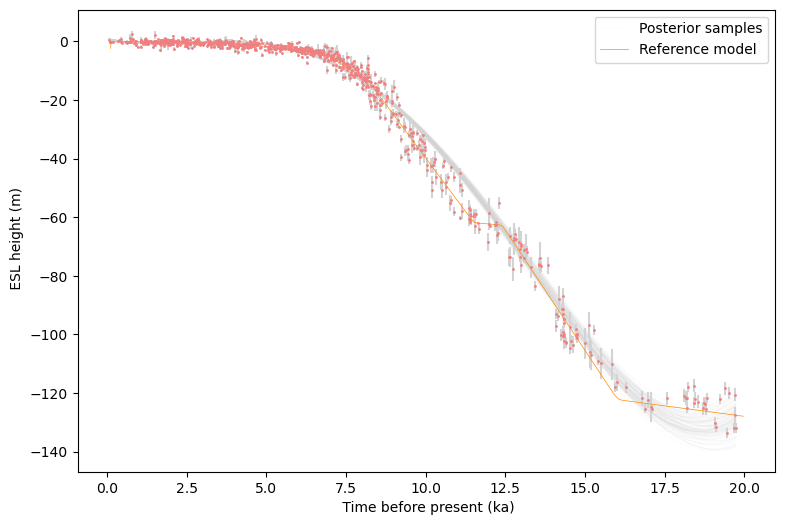

In [40]:
#@title Solution

m_lower_bound = np.array([-1.0,-10,-10,-10])             # lower bound for uniform prior
m_upper_bound = np.array([1.0,10,10,10])                 # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

######## CoFI BaseProblem - update information
inv_problem.set_log_prior(log_prior)

######## CoFI Inversion - run it
inv_4 = Inversion(inv_problem, inv_options_3)
inv_result_4 = inv_4.run()

flat_samples = inv_result_4.sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

print("Resulting samples with prior model lower bounds of [-1,-10,-10,-10], upper bounds of [2,10,10,10]")
plot_data()
plot_models(flat_samples[inds],color="lightgrey")
plot_model(ref_x, ref_y, "Reference model", color="darkorange")

Is there much change to the posterior distribution?

---

## Watermark

In [41]:
watermark_list = ["cofi", "numpy", "scipy", "matplotlib", "emcee", "arviz"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.2
numpy 1.23.5
scipy 1.10.1
matplotlib 3.7.1
emcee 3.1.4
arviz 0.15.1
